# Softmax simplex plot for 3 variables

This notebook visualises the softmax mapping for 3 variables. We take points (x, y, 0) in R^3, compute the softmax probabilities p = softmax([x, y, 0]), and plot the resulting point in the 2D probability simplex (an equilateral triangle) using barycentric coordinates. Colors correspond to the probability vector (p1, p2, p3) as RGB.

Run the Python cell below to generate the plot.

In [50]:
%pip install numpy matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [51]:
%matplotlib widget

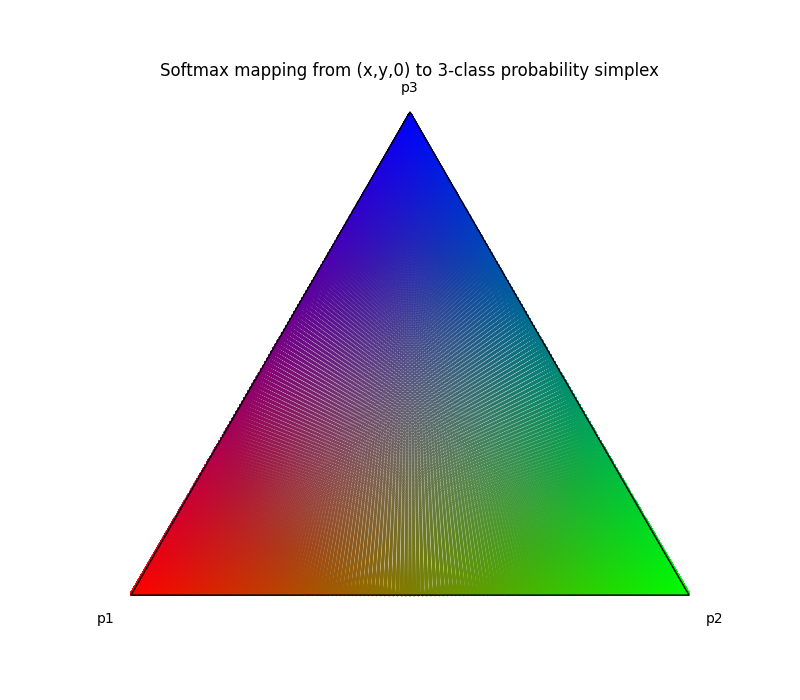

In [52]:
# Compute and plot softmax mapping onto 2D simplex
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# softmax function
def softmax(z):
    e = np.exp(z - np.max(z))
    return e / e.sum(axis=-1, keepdims=True)

# barycentric conversion: given (p1,p2,p3), map to 2D coordinates in an equilateral triangle
v1 = np.array([0.0, 0.0])
v2 = np.array([1.0, 0.0])
v3 = np.array([0.5, np.sqrt(3)/2])

def barycentric_to_xy(p):
    return p[...,0:1]*v1 + p[...,1:2]*v2 + p[...,2:3]*v3

# Create a grid in (x,y) plane; we'll set z=0 for symmetry
n = 400
xs = np.linspace(-6, 6, n)
ys = np.linspace(-6, 6, n)
X, Y = np.meshgrid(xs, ys)
Z = np.zeros_like(X)

# Stack into shape (n*n, 3)
pts = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)
P = softmax(pts)

# Map probabilities to 2D points
XY = barycentric_to_xy(P)

# Colors = probability vector as RGB
colors = P

# Plot
fig, ax = plt.subplots(figsize=(8,7))
ax.scatter(XY[:,0], XY[:,1], c=colors, s=6, alpha=0.9, linewidths=0)

# Draw simplex boundary
triangle = Polygon([v1, v2, v3], closed=True, edgecolor='k', facecolor='none')
ax.add_patch(triangle)

# Label vertices with p1, p2, p3
ax.text(v1[0]-0.03, v1[1]-0.03, 'p1', ha='right', va='top')
ax.text(v2[0]+0.03, v2[1]-0.03, 'p2', ha='left', va='top')
ax.text(v3[0], v3[1]+0.03, 'p3', ha='center', va='bottom')

ax.set_aspect('equal')
ax.set_xlim(-0.05,1.05)
ax.set_ylim(-0.05, np.sqrt(3)/2 + 0.05)
ax.axis('off')
ax.set_title('Softmax mapping from (x,y,0) to 3-class probability simplex')
plt.show()


Notes:

- We fix the third coordinate to 0 and let x,y vary over a grid; the softmax is translation-invariant along the vector (1,1,1), so this captures the 2D degrees of freedom.
- Colors show which class gets the largest probability: RGB corresponds directly to (p1,p2,p3).

### Tangent hyperplane approximation (first-order Taylor)

Below we compute the Jacobian of the softmax at several center points and build the first-order (tangent) linear approximation

p(x) ≈ p(x0) + J(x0) (x - x0)

We sample small neighborhoods around each center, compute true softmax and the linear approximation, and visualise both on the 2D simplex. Each subplot reports the mean L2 error and whether any approximated points fall outside the simplex (sum!=1 or negative components) — those approximations are 'not suitable'.

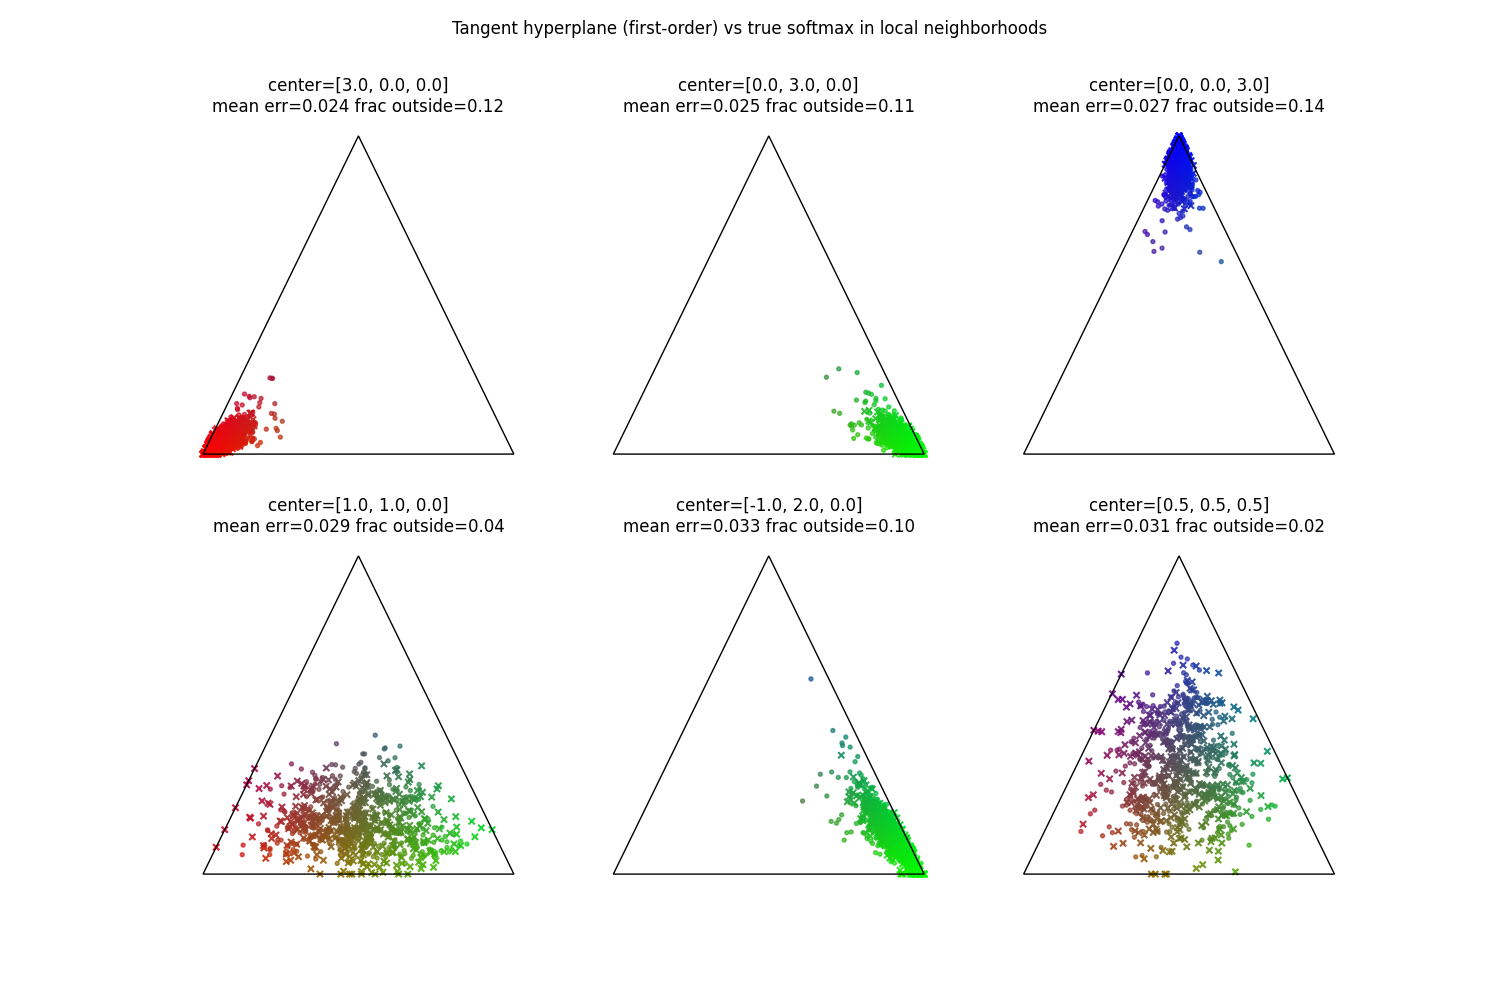

In [53]:
# Evaluate tangent (Jacobian) linear approximations and visualise on 2D simplex
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# softmax and Jacobian
def softmax(z):
    z = np.asarray(z)
    e = np.exp(z - np.max(z))
    return e / np.sum(e)

def softmax_batch(Z):
    e = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return e / np.sum(e, axis=1, keepdims=True)

def softmax_jacobian(p):
    # p is softmax output vector of shape (3,)
    # Jacobian J_ij = p_i (delta_ij - p_j)
    J = -np.outer(p, p)
    J[np.diag_indices(3)] += p
    return J

# barycentric mapping used earlier
v1 = np.array([0.0,0.0])
v2 = np.array([1.0,0.0])
v3 = np.array([0.5, np.sqrt(3)/2])

def barycentric_to_xy(p):
    return p[0]*v1 + p[1]*v2 + p[2]*v3

# choose centers in input space (3D) - e.g., points along axes and between
centers = [np.array([3.0,0.0,0.0]), np.array([0.0,3.0,0.0]), np.array([0.0,0.0,3.0]),
           np.array([1.0,1.0,0.0]), np.array([-1.0,2.0,0.0]), np.array([0.5,0.5,0.5])]

# sample neighborhood radius
eps = 0.5
n_samples = 400

fig, axes = plt.subplots(2, 3, figsize=(15,10))
for idx, x0 in enumerate(centers):
    ax = axes.flat[idx]
    p0 = softmax(x0)
    J = softmax_jacobian(p0)

    # sample local perturbations
    deltas = np.random.normal(scale=eps, size=(n_samples, 3))
    X = x0 + deltas
    P_true = softmax_batch(X)

    # linear approx in probability space (first-order)
    P_lin = p0 + (deltas @ J.T)

    # project linear approx onto simplex by simple clipping+renormalize for visual comparison (not the true Taylor)
    P_lin_clipped = np.clip(P_lin, 0, None)
    sums = P_lin_clipped.sum(axis=1, keepdims=True)
    sums[sums==0] = 1.0
    P_lin_proj = P_lin_clipped / sums

    # map to XY
    XY_true = np.array([barycentric_to_xy(p) for p in P_true])
    XY_lin = np.array([barycentric_to_xy(p) for p in P_lin_proj])

    # compute error
    err = np.linalg.norm(P_true - P_lin, axis=1)
    mean_err = err.mean()

    # check violations per-sample: negative components or sum deviating from 1
    neg_violation = np.any(P_lin < -1e-8, axis=1)            # shape (n_samples,)
    sum_deviation = np.abs(P_lin.sum(axis=1) - 1.0) > 1e-6   # shape (n_samples,)
    violation = neg_violation | sum_deviation
    outside_simplex = np.any(violation)
    frac_outside = violation.mean()

    ax.scatter(XY_true[:,0], XY_true[:,1], c=P_true, s=8, alpha=0.7, label='true')
    ax.scatter(XY_lin[:,0], XY_lin[:,1], c=P_lin_proj, s=20, marker='x', alpha=0.9, label='linear')
    triangle = Polygon([v1,v2,v3], closed=True, edgecolor='k', facecolor='none')
    ax.add_patch(triangle)
    ax.set_title(f'center={x0.tolist()}\nmean err={mean_err:.3f} frac outside={frac_outside:.2f}')
    ax.axis('off')

plt.suptitle('Tangent hyperplane (first-order) vs true softmax in local neighborhoods')
plt.show()


Explanation of the 3-class plots

- Triangle: the equilateral triangle is the 2D probability simplex for 3 classes. Each vertex corresponds to a one-hot probability vector: p1=(1,0,0), p2=(0,1,0), p3=(0,0,1). Any valid probability vector (p1,p2,p3) sits inside this triangle and can be represented by barycentric coordinates (weights for the vertices).

- Colours: points are coloured by their probability vectors. For the 3-class plots we directly map (p1,p2,p3) to RGB — so a point close to the p1 vertex appears red, close to p2 appears green, close to p3 appears blue, and mixtures blend those colours.

- True vs linear markers: in the tangent-hyperplane diagnostic plots the filled circular points show the true softmax outputs for samples in a local neighborhood (coloured by their probabilities). The 'x' markers show the linear approximation (first-order Taylor) projected back to the simplex for visual comparison.

- Metrics in titles: each subplot shows the mean L2 error between true and linearized probabilities and the fraction of sampled points for which the linear approximation produced invalid probabilities (negative components or sum ≠ 1). A high fraction indicates the linearization is not suitable at that center.

Why colours + triangle helps: the triangle geometry makes it easy to see whether approximations push points out of the simplex (they'd land outside or at the edges), and the RGB colouring gives an immediate visual cue about which class dominates and how mixtures move between classes.

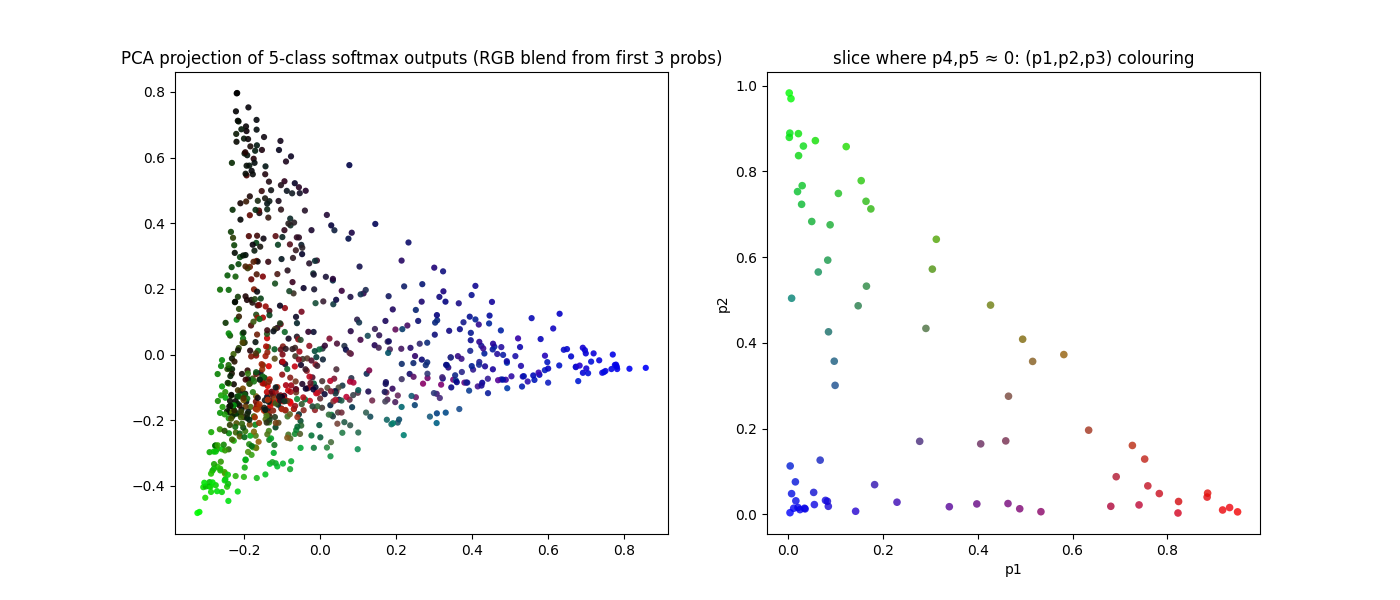

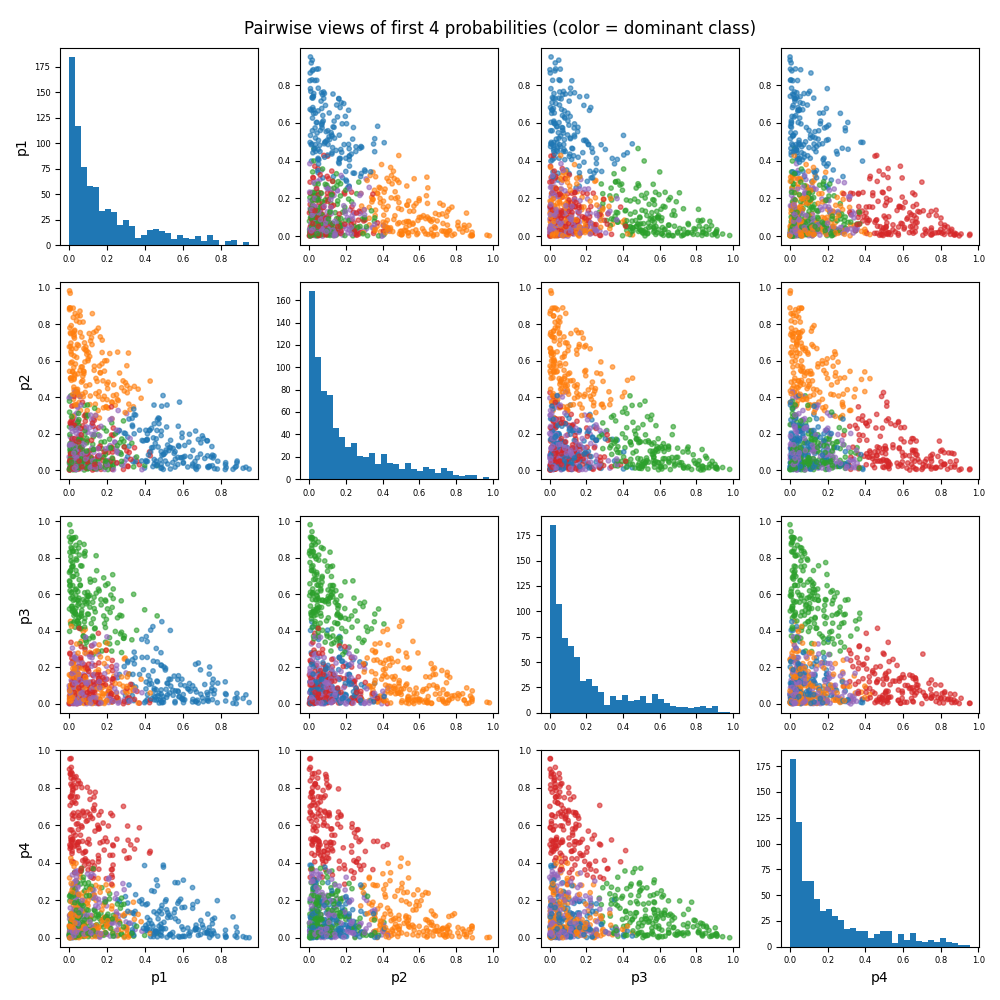

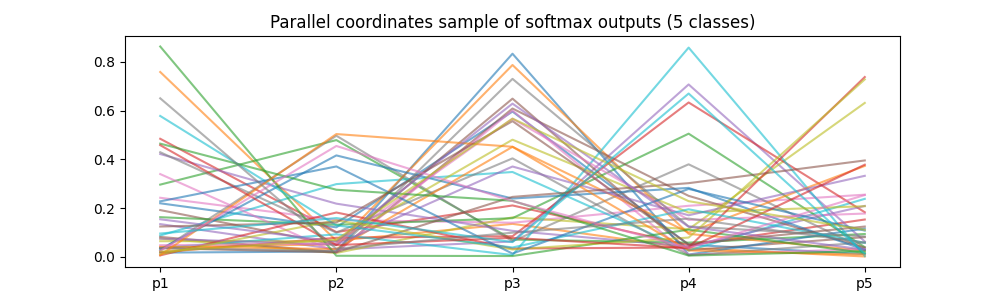

In [54]:
# Visualising softmax behaviour for 5 inputs
# We'll use PCA to project 5-d probability vectors into 2D, and also show pairwise/parallel-coordinates views.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import itertools

# softmax helper
def softmax_batch(Z):
    e = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return e / np.sum(e, axis=1, keepdims=True)

# create a grid of inputs in 5D by sampling around some centers
n_points = 800
np.random.seed(0)
inputs = np.random.normal(scale=1.5, size=(n_points, 5))
P = softmax_batch(inputs)

# derive two colorings:
# 1) RGB blend from the first 3 probabilities (useful for scatter where RGB is supported)
# 2) dominant-class index (for categorical colormap in pairwise plots)
colors_rgb = P[:, :3]
colors_idx = np.argmax(P, axis=1)

# 2D PCA projection of probability simplex
pca = PCA(n_components=2)
P2 = pca.fit_transform(P)

fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[0].scatter(P2[:,0], P2[:,1], c=colors_rgb, s=20, alpha=0.9, edgecolors='none')
ax[0].set_title('PCA projection of 5-class softmax outputs (RGB blend from first 3 probs)')

# show ternary-like slices: plot p1 vs p2 with color by p3 for a window of p4,p5 small (slice)
mask = (P[:,3] < 0.05) & (P[:,4] < 0.05)
if mask.sum()>10:
    ax[1].scatter(P[mask,0], P[mask,1], c=P[mask,:3], s=30, alpha=0.8, edgecolors='none')
    ax[1].set_xlabel('p1')
    ax[1].set_ylabel('p2')
    ax[1].set_title('slice where p4,p5 ≈ 0: (p1,p2,p3) colouring')
else:
    ax[1].text(0.5,0.5,'No thin slice found; increase samples or loosen condition', ha='center')

plt.show()

# Pairwise scatter matrix for first 4 classes (to save space)
classes = 4
fig, axes = plt.subplots(classes, classes, figsize=(10,10))
cmap = plt.cm.tab10
for i,j in itertools.product(range(classes), range(classes)):
    axp = axes[i,j]
    if i==j:
        axp.hist(P[:,i], bins=30, color='C0')
    else:
        axp.scatter(P[:,j], P[:,i], c=colors_idx, cmap=cmap, s=10, alpha=0.6, vmin=0, vmax=9)
    if i==classes-1:
        axp.set_xlabel(f'p{j+1}')
    if j==0:
        axp.set_ylabel(f'p{i+1}')
    axp.tick_params(labelsize=6)
plt.suptitle('Pairwise views of first 4 probabilities (color = dominant class)')
plt.tight_layout()
plt.show()

# Parallel coordinates for a subset of points
def parallel_coords_plot(P, idxs, axp):
    for i in idxs:
        axp.plot(range(1,P.shape[1]+1), P[i], alpha=0.6)
    axp.set_xticks(range(1,P.shape[1]+1))
    axp.set_xticklabels([f'p{k+1}' for k in range(P.shape[1])])

fig, axp = plt.subplots(1,1,figsize=(10,3))
parallel_coords_plot(P, np.random.choice(len(P), size=40, replace=False), axp)
axp.set_title('Parallel coordinates sample of softmax outputs (5 classes)')
plt.show()

In [55]:
%pip install ipympl

Note: you may need to restart the kernel to use updated packages.


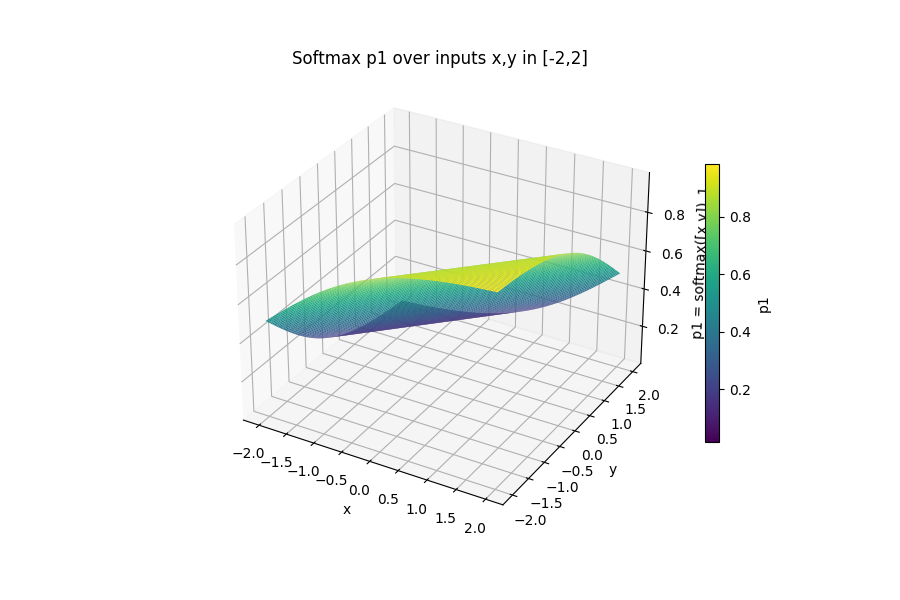

In [56]:
%matplotlib widget
# 3D surface plot of softmax output p1 for two inputs over [-2,2]
# Note: we subtract the per-row max before exponentiating for numerical stability.
# This shift does NOT change the softmax result (softmax is shift-invariant),
# but it prevents overflow when input values are large.
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D projection)
# If '%matplotlib widget' errors, try '%matplotlib notebook' or install ipympl (pip install ipympl).

def softmax2(Z):
    Z = np.asarray(Z)
    # Z shape (..., 2)
    # subtract max per-row for numerical stability (doesn't change result)
    e = np.exp(Z - np.max(Z, axis=-1, keepdims=True))
    return e / np.sum(e, axis=-1, keepdims=True)

# grid in input space
n = 201
xs = np.linspace(-2.0, 2.0, n)
ys = np.linspace(-2.0, 2.0, n)
X, Y = np.meshgrid(xs, ys)
pts = np.stack([X, Y], axis=-1)  # shape (n, n, 2)

# evaluate softmax on grid and extract p1
P = softmax2(pts.reshape(-1, 2)).reshape(n, n, 2)
Zp1 = P[:, :, 0]

# plot surface (interactive: click+drag to rotate, scroll to zoom)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Zp1, cmap='viridis', linewidth=0, antialiased=True, rcount=200, ccount=200)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('p1 = softmax([x,y])_1')
ax.set_title('Softmax p1 over inputs x,y in [-2,2]')
fig.colorbar(surf, ax=ax, shrink=0.6, label='p1')
plt.show()

In [57]:
%pip install ipympl

Note: you may need to restart the kernel to use updated packages.


In [58]:
%pip install ipympl==0.9.1

  Using cached ipympl-0.9.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached ipywidgets-7.8.5-py2.py3-none-any.whl.metadata (1.9 kB)
  Using cached widgetsnbextension-3.6.10-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached jupyterlab_widgets-1.1.11-py3-none-any.whl.metadata (3.7 kB)
  Using cached notebook-7.4.7-py3-none-any.whl.metadata (10 kB)
  Using cached jupyter_server-2.14.2-py3-none-any.whl.metadata (8.4 kB)
  Using cached jupyterlab_server-2.27.3-py3-none-any.whl.metadata (5.9 kB)
INFO: pip is looking at multiple versions of notebook to determine which version is compatible with other requirements. This could take a while.
  Using cached notebook-7.4.6-py3-none-any.whl.metadata (10 kB)
  Using cached notebook-7.4.5-py3-none-any.whl.metadata (10 kB)
  Using cached notebook-7.4.4-py3-none-any.whl.metadata (10 kB)
  Using cached notebook-7.4.3-py3-none-any.whl.metadata (10 kB)
  Using cached notebook-7.4.2-py3-none-any.whl.metadata (10 kB)
  Using cached notebook-7.4.1-

  error: subprocess-exited-with-error
  
  × pip subprocess to install backend dependencies did not run successfully.
  │ exit code: 1
  ╰─> [3 lines of output]
      ERROR: Ignored the following versions that require a different python version: 0.1.0 Requires-Python >=3.9; 0.1.1 Requires-Python >=3.9; 0.1.2 Requires-Python >=3.9; 0.1.3 Requires-Python >=3.9; 0.1.4 Requires-Python >=3.9; 0.1.5 Requires-Python >=3.9
      ERROR: Could not find a version that satisfies the requirement puccinialin (from versions: none)
      ERROR: No matching distribution found for puccinialin
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× pip subprocess to install backend dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [62]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_softmax_3d(x_range=(-5, 5), resolution=50):
    """
    Plot softmax function for 2 inputs in 3D with full interactivity.
    Works perfectly in Jupyter notebooks!
    
    Parameters:
    -----------
    x_range : tuple
        Range of input values (min, max)
    resolution : int
        Number of points along each axis
    """
    # Create grid of input values
    x1 = np.linspace(x_range[0], x_range[1], resolution)
    x2 = np.linspace(x_range[0], x_range[1], resolution)
    X1, X2 = np.meshgrid(x1, x2)
    
    # Compute softmax outputs
    exp_x1 = np.exp(X1)
    exp_x2 = np.exp(X2)
    sum_exp = exp_x1 + exp_x2
    
    softmax_1 = exp_x1 / sum_exp
    softmax_2 = exp_x2 / sum_exp
    
    # Create subplots for both softmax outputs
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=('Softmax Output 1', 'Softmax Output 2'),
        specs=[[{'type': 'surface'}, {'type': 'surface'}]],
        horizontal_spacing=0.1
    )
    
    # Add first softmax surface
    fig.add_trace(
        go.Surface(
            x=X1, y=X2, z=softmax_1,
            colorscale='Viridis',
            name='Softmax 1',
            showscale=True,
            hovertemplate='x1: %{x:.2f}<br>x2: %{y:.2f}<br>Output: %{z:.3f}<extra></extra>'
        ),
        row=1, col=1
    )
    
    # Add second softmax surface
    fig.add_trace(
        go.Surface(
            x=X1, y=X2, z=softmax_2,
            colorscale='Plasma',
            name='Softmax 2',
            showscale=True,
            hovertemplate='x1: %{x:.2f}<br>x2: %{y:.2f}<br>Output: %{z:.3f}<extra></extra>'
        ),
        row=1, col=2
    )
    
    # Update layout
    fig.update_layout(
        title_text="Softmax Function for 2 Inputs - Drag to Rotate!",
        height=600,
        showlegend=False
    )
    
    # Update 3D scene properties for both subplots
    fig.update_scenes(
        xaxis_title="Input x1",
        yaxis_title="Input x2",
        zaxis_title="Softmax Output",
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.3)
        )
    )
    
    fig.show()
    
    return fig

def plot_softmax_combined(x_range=(-5, 5), resolution=50):
    """
    Plot both softmax outputs on a single 3D plot.
    Fully interactive - drag to rotate, scroll to zoom!
    """
    # Create grid
    x1 = np.linspace(x_range[0], x_range[1], resolution)
    x2 = np.linspace(x_range[0], x_range[1], resolution)
    X1, X2 = np.meshgrid(x1, x2)
    
    # Compute softmax
    exp_x1 = np.exp(X1)
    exp_x2 = np.exp(X2)
    sum_exp = exp_x1 + exp_x2
    
    softmax_1 = exp_x1 / sum_exp
    softmax_2 = exp_x2 / sum_exp
    
    # Create figure
    fig = go.Figure()
    
    # Add both surfaces
    fig.add_trace(go.Surface(
        x=X1, y=X2, z=softmax_1,
        colorscale='Blues',
        name='Softmax 1',
        opacity=0.85,
        showscale=True,
        hovertemplate='<b>Softmax 1</b><br>x1: %{x:.2f}<br>x2: %{y:.2f}<br>Output: %{z:.3f}<extra></extra>'
    ))
    
    fig.add_trace(go.Surface(
        x=X1, y=X2, z=softmax_2,
        colorscale='Reds',
        name='Softmax 2',
        opacity=0.85,
        showscale=True,
        hovertemplate='<b>Softmax 2</b><br>x1: %{x:.2f}<br>x2: %{y:.2f}<br>Output: %{z:.3f}<extra></extra>'
    ))
    
    fig.update_layout(
        title="Softmax Functions (Both Outputs) - Interactive 3D",
        scene=dict(
            xaxis_title="Input x1",
            yaxis_title="Input x2",
            zaxis_title="Softmax Output",
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.3)
            )
        ),
        height=700
    )
    
    fig.show()
    
    return fig

def plot_softmax_single(x_range=(-5, 5), resolution=50, which=1):
    """
    Plot a single softmax output in a large interactive plot.
    
    Parameters:
    -----------
    which : int (1 or 2)
        Which softmax output to plot
    """
    # Create grid
    x1 = np.linspace(x_range[0], x_range[1], resolution)
    x2 = np.linspace(x_range[0], x_range[1], resolution)
    X1, X2 = np.meshgrid(x1, x2)
    
    # Compute softmax
    exp_x1 = np.exp(X1)
    exp_x2 = np.exp(X2)
    sum_exp = exp_x1 + exp_x2
    
    if which == 1:
        softmax_output = exp_x1 / sum_exp
        colorscale = 'Viridis'
        title = 'Softmax Output 1'
    else:
        softmax_output = exp_x2 / sum_exp
        colorscale = 'Plasma'
        title = 'Softmax Output 2'
    
    # Create figure
    fig = go.Figure(data=[go.Surface(
        x=X1, y=X2, z=softmax_output,
        colorscale=colorscale,
        hovertemplate='x1: %{x:.2f}<br>x2: %{y:.2f}<br>Output: %{z:.3f}<extra></extra>'
    )])
    
    fig.update_layout(
        title=f'{title} - Interactive 3D (Drag to Rotate, Scroll to Zoom)',
        scene=dict(
            xaxis_title="Input x1",
            yaxis_title="Input x2",
            zaxis_title="Softmax Output",
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.3)
            )
        ),
        height=700
    )
    
    fig.show()
    
    return fig

In [66]:
print("Creating interactive 3D Plotly plots...")
print("\nControls:")
print("- Click and drag to rotate")
print("- Scroll to zoom in/out")
print("- Hover over surface to see values")
print()

# Plot both outputs separately
fig1 = plot_softmax_3d(x_range=(-5, 5), resolution=50)

# Plot both outputs together
fig2 = plot_softmax_combined(x_range=(-5, 5), resolution=50)

# Plot single output (optional)
# fig3 = plot_softmax_single(x_range=(-5, 5), resolution=50, which=1)

Creating interactive 3D Plotly plots...

Controls:
- Click and drag to rotate
- Scroll to zoom in/out
- Hover over surface to see values



ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [69]:
%pip install seaborn

  Using cached pandas-2.0.3-cp38-cp38-win_amd64.whl.metadata (18 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.0.3-cp38-cp38-win_amd64.whl (10.8 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Note: you may need to restart the kernel to use updated packages.


In [74]:
import numpy as np

# --- Helper functions for Interval Arithmetic ---
# We represent an interval as a tuple (low, high)

def add_intervals(i1, i2):
    """Adds two intervals: [a, b] + [c, d] = [a+c, b+d]"""
    return (i1[0] + i2[0], i1[1] + i2[1])

def sub_intervals(i1, i2):
    """Subtracts two intervals: [a, b] - [c, d] = [a-d, b-c]"""
    return (i1[0] - i2[1], i1[1] - i2[0])

def mul_intervals(i1, i2):
    """Multiplies two intervals: [a, b] * [c, d]"""
    products = [i1[0] * i2[0], i1[0] * i2[1], i1[1] * i2[0], i1[1] * i2[1]]
    return (min(products), max(products))

def neg_interval(i):
    """Negates an interval: -[a, b] = [-b, -a]"""
    return (-i[1], -i[0])

def mag_interval(i):
    """Calculates the magnitude of an interval: max(|a|, |b|)"""
    return max(abs(i[0]), abs(i[1]))

# --- Core Softmax and Hessian Functions ---

def softmax(z):
    """Computes the numerically stable softmax of a vector z."""
    shift_z = z - np.max(z)
    exps = np.exp(shift_z)
    return exps / np.sum(exps)

def get_softmax_output_bounds(logit_box):
    """
    Calculates the interval bounds [s_j^L, s_j^U] for each softmax output s_j
    over the given logit_box.
    
    To minimize s_j: set z_j to its lower bound and all other z_k to their upper bounds.
    To maximize s_j: set z_j to its upper bound and all other z_k to their lower bounds.
    """
    K = len(logit_box)
    s_intervals = []
    
    for j in range(K):
        # To find the minimum of s_j, set z_j to its lower bound and all other
        # z_k to their upper bounds.
        z_for_min = [logit_box[k][1] for k in range(K)]
        z_for_min[j] = logit_box[j][0]
        s_min = softmax(np.array(z_for_min))[j]
        
        # To find the maximum of s_j, set z_j to its upper bound and all other
        # z_k to their lower bounds.
        z_for_max = [logit_box[k][0] for k in range(K)]
        z_for_max[j] = logit_box[j][1]
        s_max = softmax(np.array(z_for_max))[j]
        
        s_intervals.append((s_min, s_max))
        
    return s_intervals

# --- STEP 1: Create the Interval Hessian ---

def create_interval_hessian(s_intervals, i):
    """
    Creates the interval Hessian matrix for the i-th softmax component.
    
    Formula for Hessian of s_i with respect to z_j and z_k:
    H_i(j,k) = ∂²s_i/∂z_j∂z_k = s_i(δ_ij - s_j)(δ_ik - s_k) - s_i*s_j*(δ_jk - s_k)
    
    where δ_ij is the Kronecker delta (1 if i==j, 0 otherwise)
    """
    K = len(s_intervals)
    interval_hessian = [[(0.0, 0.0) for _ in range(K)] for _ in range(K)]
    s_i = s_intervals[i]

    for j in range(K):
        for k in range(K):
            delta_ij = 1.0 if i == j else 0.0
            delta_ik = 1.0 if i == k else 0.0
            delta_jk = 1.0 if j == k else 0.0

            s_j = s_intervals[j]
            s_k = s_intervals[k]

            # First term: s_i * (δ_ij - s_j) * (δ_ik - s_k)
            term1_factor1 = sub_intervals((delta_ij, delta_ij), s_j)
            term1_factor2 = sub_intervals((delta_ik, delta_ik), s_k)
            term1 = mul_intervals(s_i, mul_intervals(term1_factor1, term1_factor2))

            # Second term: s_i * s_j * (δ_jk - s_k)
            term2_factor = sub_intervals((delta_jk, delta_jk), s_k)
            term2 = mul_intervals(s_i, mul_intervals(s_j, term2_factor))
            
            # H_i(j,k) = term1 - term2
            interval_hessian[j][k] = sub_intervals(term1, term2)
            
    return interval_hessian

# --- STEP 2: Bound Eigenvalues with Gershgorin Circles ---

def bound_eigenvalues_gershgorin(interval_hessian):
    """
    Uses Gershgorin's theorem to find an interval [lambda_min, lambda_max]
    that is guaranteed to contain all eigenvalues of any concrete matrix
    within the interval Hessian.
    
    Gershgorin Theorem: Every eigenvalue λ of a matrix A lies within at least 
    one of the Gershgorin discs: |λ - A_ii| ≤ Σ_{j≠i} |A_ij|
    """
    K = len(interval_hessian)
    gershgorin_intervals = []

    for i in range(K):
        center_interval = interval_hessian[i][i]
        
        # Radius is the sum of magnitudes of off-diagonal elements in row i
        radius = 0.0
        for j in range(K):
            if i != j:
                radius += mag_interval(interval_hessian[i][j])
        
        # Gershgorin interval for row i: [center_low - radius, center_high + radius]
        g_interval = (center_interval[0] - radius, center_interval[1] + radius)
        gershgorin_intervals.append(g_interval)

    # The final bound is the union of all individual Gershgorin intervals
    lambda_min = min(g[0] for g in gershgorin_intervals)
    lambda_max = max(g[1] for g in gershgorin_intervals)
    
    return lambda_min, lambda_max, gershgorin_intervals

# --- STEP 3: Classify the Curvature ---

def classify_curvature(lambda_min, lambda_max, tolerance=1e-6):
    """
    Classifies the shape based on the signs of the eigenvalue bounds.
    
    - If λ_min > 0 (within tolerance): Convex (positive definite)
    - If λ_max < 0 (within tolerance): Concave (negative definite)  
    - Otherwise: Indefinite (saddle shape)
    """
    if lambda_min > tolerance:
        return "Convex (positive definite)"
    elif lambda_max < -tolerance:
        return "Concave (negative definite)"
    else:
        return "Indefinite (saddle)"

# --- Verification: Sample-based checking ---

def verify_bounds_sampling(logit_box, s_intervals, num_samples=1000):
    """
    Verify the computed bounds by sampling random points in the logit box.
    This is for verification only - not used for soundness!
    """
    K = len(logit_box)
    np.random.seed(42)
    
    violations = []
    for _ in range(num_samples):
        # Sample random point in box
        z = np.array([np.random.uniform(logit_box[k][0], logit_box[k][1]) 
                      for k in range(K)])
        s = softmax(z)
        
        # Check if softmax values are within computed bounds
        for k in range(K):
            if s[k] < s_intervals[k][0] - 1e-6 or s[k] > s_intervals[k][1] + 1e-6:
                violations.append((z, s, k))
    
    return violations

# --- Main Execution with Multiple Examples ---

def analyze_softmax_curvature(logit_box, component_idx=0, verbose=True):
    """
    Complete curvature analysis for a softmax component over a logit box.
    
    Returns:
        dict with keys: 's_intervals', 'interval_H', 'lambda_min', 'lambda_max', 
                       'gershgorin_intervals', 'classification'
    """
    K = len(logit_box)
    
    if verbose:
        print(f"\n{'='*70}")
        print(f"SOFTMAX CURVATURE ANALYSIS: Component s_{component_idx + 1}")
        print(f"{'='*70}")
        print(f"Logit box (input bounds):")
        for i, bounds in enumerate(logit_box):
            print(f"  z_{i+1}: [{bounds[0]:.4f}, {bounds[1]:.4f}]")
        print("-" * 70)

    # Step 0: Get bounds on softmax outputs
    s_intervals = get_softmax_output_bounds(logit_box)
    
    if verbose:
        print("STEP 0: Softmax Output Bounds [s_j^L, s_j^U]")
        for i, bounds in enumerate(s_intervals):
            print(f"  s_{i+1}: [{bounds[0]:.6f}, {bounds[1]:.6f}]")
        print("-" * 70)

    # Step 1: Create Interval Hessian
    interval_H = create_interval_hessian(s_intervals, component_idx)
    
    if verbose:
        print(f"STEP 1: Interval Hessian Matrix H_{component_idx + 1}")
        for i, row in enumerate(interval_H):
            row_str = "  [" + ", ".join(f"[{v[0]:7.4f}, {v[1]:7.4f}]" for v in row) + "]"
            print(row_str)
        print("-" * 70)

    # Step 2: Apply Gershgorin Circle Theorem
    lambda_min, lambda_max, g_intervals = bound_eigenvalues_gershgorin(interval_H)
    
    if verbose:
        print("STEP 2: Gershgorin Circle Bounds")
        for i, g_int in enumerate(g_intervals):
            print(f"  Row {i+1}: [{g_int[0]:8.5f}, {g_int[1]:8.5f}]")
        print(f"\n  Union (final eigenvalue bound):")
        print(f"  [λ_min, λ_max] = [{lambda_min:.6f}, {lambda_max:.6f}]")
        print("-" * 70)

    # Step 3: Classify curvature
    classification = classify_curvature(lambda_min, lambda_max)
    
    if verbose:
        print("STEP 3: Curvature Classification")
        print(f"  Result: {classification}")
        print("-" * 70)
        
        print("\nIMPLICATIONS FOR APPROXIMATION:")
        if "Indefinite" in classification:
            print("  ⚠️  SADDLE SHAPE: Tangent planes are UNSOUND")
            print("  ✓  Must use LSE-based or chord-based envelopes")
        elif "Convex" in classification:
            print("  ✓  CONVEX: Tangent plane is sound LOWER bound")
            print("  ⚠️  Need different method for upper bound")
        else:  # Concave
            print("  ✓  CONCAVE: Tangent plane is sound UPPER bound")
            print("  ⚠️  Need different method for lower bound")
        print("=" * 70)
    
    return {
        's_intervals': s_intervals,
        'interval_H': interval_H,
        'lambda_min': lambda_min,
        'lambda_max': lambda_max,
        'gershgorin_intervals': g_intervals,
        'classification': classification
    }
    

In [75]:
# Example 1: Competitive regime (mixed curvature expected)
print("\n\n" + "="*70)
print("EXAMPLE 1: Competitive Regime (5 inputs)")
print("="*70)
logit_box_competitive = [
    (2.0, 3.0),   # z1
    (2.5, 3.5),   # z2
    (0.0, 1.0),   # z3
    (-1.0, 0.0),  # z4
    (-2.0, -1.0)  # z5
]
result1 = analyze_softmax_curvature(logit_box_competitive, component_idx=0)

# Verify with sampling
violations = verify_bounds_sampling(logit_box_competitive, result1['s_intervals'])
print(f"\nVerification: {len(violations)} violations out of 1000 samples")


# Example 2: Dominant regime (more likely convex)
print("\n\n" + "="*70)
print("EXAMPLE 2: Dominant Regime (4 inputs)")
print("="*70)
logit_box_dominant = [
    (5.0, 6.0),   # z1 - strongly dominant
    (0.0, 1.0),   # z2
    (-1.0, 0.5),  # z3
    (-2.0, 0.0),  # z4
]
result2 = analyze_softmax_curvature(logit_box_dominant, component_idx=0)


# Example 3: Small perturbation around a point
print("\n\n" + "="*70)
print("EXAMPLE 3: Small Perturbation (3 inputs)")
print("="*70)
center = np.array([1.0, 0.5, -0.5])
epsilon = 0.1
logit_box_small = [(c - epsilon, c + epsilon) for c in center]
result3 = analyze_softmax_curvature(logit_box_small, component_idx=0)


# Summary comparison
print("\n\n" + "="*70)
print("SUMMARY COMPARISON")
print("="*70)
examples = [
    ("Competitive", result1),
    ("Dominant", result2),
    ("Small Pert.", result3)
]

print(f"\n{'Regime':<15} {'λ_min':<12} {'λ_max':<12} {'Classification':<30}")
print("-" * 70)
for name, result in examples:
    print(f"{name:<15} {result['lambda_min']:>11.6f} {result['lambda_max']:>11.6f}  "
            f"{result['classification']:<30}")



EXAMPLE 1: Competitive Regime (5 inputs)

SOFTMAX CURVATURE ANALYSIS: Component s_1
Logit box (input bounds):
  z_1: [2.0000, 3.0000]
  z_2: [2.5000, 3.5000]
  z_3: [0.0000, 1.0000]
  z_4: [-1.0000, 0.0000]
  z_5: [-2.0000, -1.0000]
----------------------------------------------------------------------
STEP 0: Softmax Output Bounds [s_j^L, s_j^U]
  s_1: [0.165709, 0.594753]
  s_2: [0.335106, 0.788318]
  s_3: [0.017996, 0.119259]
  s_4: [0.006493, 0.046068]
  s_5: [0.002372, 0.017265]
----------------------------------------------------------------------
STEP 1: Interval Hessian Matrix H_1
  [[-0.2679,  0.4028], [-0.3820,  0.2563], [-0.0587,  0.0410], [-0.0227,  0.0159], [-0.0085,  0.0059]]
  [[-0.3820,  0.2563], [-0.2931,  0.3579], [ 0.0020,  0.1118], [ 0.0007,  0.0432], [ 0.0003,  0.0162]]
  [[-0.0587,  0.0410], [ 0.0020,  0.1118], [-0.0696,  0.0058], [ 0.0000,  0.0065], [ 0.0000,  0.0024]]
  [[-0.0227,  0.0159], [ 0.0007,  0.0432], [ 0.0000,  0.0065], [-0.0272,  0.0002], [ 0.0000, 

In [1]:
import numpy as np
import itertools
from scipy.optimize import linprog

def lse(z):
    """
    Numerically stable Log-Sum-Exp.
    LSE(z) = log(Σⱼ exp(zⱼ))
    """
    z_max = np.max(z)
    return z_max + np.log(np.sum(np.exp(z - z_max)))

def lse_gradient(z):
    """
    Gradient of LSE is softmax!
    ∇LSE(z) = softmax(z)
    """
    return softmax(z)

def softmax(z):
    """Standard softmax."""
    z_shifted = z - np.max(z)
    exps = np.exp(z_shifted)
    return exps / np.sum(exps)

# ============================================================
# METHOD 1: Single Tangent Plane to LSE
# ============================================================

def lse_tangent_lower_bound(z_point):
    """
    Creates a linear lower bound on LSE at point z_point.
    
    Since LSE is convex:
    LSE(z) ≥ LSE(z*) + ∇LSE(z*) · (z - z*)
    
    Returns: coefficients (c₀, c₁, ..., cₖ) such that
             LSE_lower(z) = c₀ + Σᵢ cᵢ·zᵢ
    """
    K = len(z_point)
    
    lse_val = lse(z_point)
    grad_lse = lse_gradient(z_point)  # = softmax(z_point)
    
    # LSE_lower(z) = lse_val + grad · (z - z_point)
    #              = lse_val - grad·z_point + grad·z
    #              = (lse_val - grad·z_point) + Σᵢ gradᵢ·zᵢ
    
    c0 = lse_val - np.dot(grad_lse, z_point)
    coeffs = grad_lse  # c₁, c₂, ..., cₖ
    
    return c0, coeffs

def softmax_upper_bound_from_lse_lower(z_bounds, output_idx, z_tangent_point):
    """
    Upper bound on softmax component i using LSE lower bound.
    
    sᵢ(z) = exp(zᵢ - LSE(z))
          ≤ exp(zᵢ - LSE_lower(z))
    
    LSE_lower(z) = c₀ + Σⱼ cⱼ·zⱼ
    
    So: sᵢ(z) ≤ exp(zᵢ - c₀ - Σⱼ cⱼ·zⱼ)
    
    This is exponential, not linear! We need to linearize it.
    """
    K = len(z_bounds)
    i = output_idx
    
    # Get LSE lower bound coefficients
    c0, coeffs = lse_tangent_lower_bound(z_tangent_point)
    
    # Now we have: sᵢ(z) ≤ exp(zᵢ - c₀ - Σⱼ cⱼ·zⱼ)
    # 
    # Problem: This is still exponential!
    # Solution: Linearize the exponential over the box
    
    # Define: φ(z) = zᵢ - c₀ - Σⱼ cⱼ·zⱼ
    #              = zᵢ - c₀ - Σⱼ≠ᵢ cⱼ·zⱼ - cᵢ·zᵢ
    #              = (1 - cᵢ)·zᵢ - c₀ - Σⱼ≠ᵢ cⱼ·zⱼ
    
    # Bound φ over the box
    phi_min, phi_max = bound_linear_function_over_box(
        c0, coeffs, i, z_bounds
    )
    
    # Now linearize exp(φ) over [φ_min, φ_max]
    # Use chord (secant line)
    exp_lower_slope = (np.exp(phi_max) - np.exp(phi_min)) / (phi_max - phi_min)
    exp_lower_intercept = np.exp(phi_min) - exp_lower_slope * phi_min
    
    # Final linear upper bound on sᵢ:
    # sᵢ(z) ≤ exp_lower_intercept + exp_lower_slope · φ(z)
    
    return construct_linear_bound(
        exp_lower_intercept, exp_lower_slope,
        c0, coeffs, i, z_bounds
    )

def bound_linear_function_over_box(c0, coeffs, target_idx, z_bounds):
    """
    Bounds the linear function:
    φ(z) = (1 - cᵢ)·zᵢ - c₀ - Σⱼ≠ᵢ cⱼ·zⱼ
    over the box z_bounds.
    """
    K = len(z_bounds)
    i = target_idx
    
    # φ(z) = -c₀ + (1 - cᵢ)·zᵢ - Σⱼ≠ᵢ cⱼ·zⱼ
    
    phi_min = -c0
    phi_max = -c0
    
    # Coefficient for zᵢ
    coeff_i = 1 - coeffs[i]
    if coeff_i >= 0:
        phi_min += coeff_i * z_bounds[i][0]
        phi_max += coeff_i * z_bounds[i][1]
    else:
        phi_min += coeff_i * z_bounds[i][1]
        phi_max += coeff_i * z_bounds[i][0]
    
    # Coefficients for zⱼ (j ≠ i)
    for j in range(K):
        if j == i:
            continue
        
        if -coeffs[j] >= 0:
            phi_min += (-coeffs[j]) * z_bounds[j][0]
            phi_max += (-coeffs[j]) * z_bounds[j][1]
        else:
            phi_min += (-coeffs[j]) * z_bounds[j][1]
            phi_max += (-coeffs[j]) * z_bounds[j][0]
    
    return phi_min, phi_max

# ============================================================
# METHOD 2: Multiple Tangent Planes (Tighter)
# ============================================================

def lse_lower_envelope_multiple_tangents(z_bounds, num_points=5):
    """
    Creates a tighter LSE lower bound using multiple tangent planes.
    
    LSE_lower(z) = max over k of: LSE(z⁽ᵏ⁾) + ∇LSE(z⁽ᵏ⁾) · (z - z⁽ᵏ⁾)
    
    In linear programming form:
    LSE_lower(z) ≥ c₀⁽ᵏ⁾ + Σᵢ cᵢ⁽ᵏ⁾·zᵢ  for all k
    """
    K = len(z_bounds)
    
    # Sample points strategically
    sample_points = generate_strategic_points(z_bounds, num_points)
    
    tangent_planes = []
    for z_point in sample_points:
        c0, coeffs = lse_tangent_lower_bound(z_point)
        tangent_planes.append((c0, coeffs))
    
    return tangent_planes

def generate_strategic_points(z_bounds, num_points):
    """
    Generate strategic points for tangent planes.
    """
    K = len(z_bounds)
    
    points = []
    
    # 1. Center point
    center = np.array([(l + u) / 2 for l, u in z_bounds])
    points.append(center)
    
    # 2. Corner points (all 2^K combinations)
    if 2**K <= num_points:
        for corner in itertools.product(*z_bounds):
            points.append(np.array(corner))
    
    # 3. Face centers (if space remains)
    if len(points) < num_points:
        for i in range(K):
            # Lower face
            p_low = center.copy()
            p_low[i] = z_bounds[i][0]
            points.append(p_low)
            
            # Upper face
            p_high = center.copy()
            p_high[i] = z_bounds[i][1]
            points.append(p_high)
    
    return points[:num_points]

# ============================================================
# METHOD 3: Complete Sound Bounds (Practical Implementation)
# ============================================================

def sound_softmax_bounds_lse(z_bounds, output_idx):
    """
    Complete LSE-based softmax approximation.
    
    Returns:
        lower_bound: (c₀, c₁, ..., cₖ) for linear lower bound
        upper_bound: (c₀, c₁, ..., cₖ) for linear upper bound
    """
    K = len(z_bounds)
    i = output_idx
    
    # ===== UPPER BOUND =====
    # Use LSE lower bound → softmax upper bound
    
    # Generate multiple LSE tangent planes
    tangent_planes = lse_lower_envelope_multiple_tangents(z_bounds, num_points=10)
    
    # For each tangent plane, create softmax upper bound
    upper_candidates = []
    for c0_lse, coeffs_lse in tangent_planes:
        upper = create_softmax_upper_from_lse_lower(
            c0_lse, coeffs_lse, i, z_bounds
        )
        upper_candidates.append(upper)
    
    # Choose tightest (minimum over box)
    best_upper = choose_tightest_upper(upper_candidates, z_bounds)
    
    # ===== LOWER BOUND =====
    # Use LSE upper bound → softmax lower bound
    
    # For LSE upper bound, use chord (secant) through corners
    lse_corners = [lse(np.array(corner)) for corner in itertools.product(*z_bounds)]
    lse_upper_value = max(lse_corners)
    
    # Or use convex hull of LSE evaluated at corners
    # This gives: LSE(z) ≤ LSE_upper (constant or linear)
    
    # Simplified: Use max corner value as constant upper bound
    # sᵢ(z) ≥ exp(zᵢ - lse_upper_value)
    
    # Linearize this exponential
    lower = linearize_exponential_lower(i, lse_upper_value, z_bounds)
    
    return lower, best_upper

def create_softmax_upper_from_lse_lower(c0_lse, coeffs_lse, output_idx, z_bounds):
    """
    Given LSE_lower(z) = c₀ + Σⱼ cⱼ·zⱼ,
    create linear upper bound on sᵢ(z) ≤ exp(zᵢ - LSE_lower(z)).
    """
    i = output_idx
    K = len(z_bounds)
    
    # φ(z) = zᵢ - LSE_lower(z)
    #      = zᵢ - c₀ - Σⱼ cⱼ·zⱼ
    #      = -c₀ + (1 - cᵢ)·zᵢ - Σⱼ≠ᵢ cⱼ·zⱼ
    
    # Bound φ(z) over the box
    phi_coeffs = np.zeros(K)
    phi_coeffs[i] = 1 - coeffs_lse[i]
    for j in range(K):
        if j != i:
            phi_coeffs[j] = -coeffs_lse[j]
    
    phi_min = -c0_lse
    phi_max = -c0_lse
    
    for j in range(K):
        if phi_coeffs[j] >= 0:
            phi_min += phi_coeffs[j] * z_bounds[j][0]
            phi_max += phi_coeffs[j] * z_bounds[j][1]
        else:
            phi_min += phi_coeffs[j] * z_bounds[j][1]
            phi_max += phi_coeffs[j] * z_bounds[j][0]
    
    # Linearize exp(φ) over [phi_min, phi_max]
    # Chord method (sound upper bound for convex function):
    if phi_max - phi_min < 1e-10:
        # Degenerate case
        slope = np.exp(phi_min)
        intercept = 0
    else:
        slope = (np.exp(phi_max) - np.exp(phi_min)) / (phi_max - phi_min)
        intercept = np.exp(phi_min) - slope * phi_min
    
    # sᵢ(z) ≤ exp(φ(z)) ≤ intercept + slope · φ(z)
    #                    = intercept + slope · (-c₀ + Σⱼ φ_coeffsⱼ·zⱼ)
    #                    = (intercept - slope·c₀) + Σⱼ (slope·φ_coeffsⱼ)·zⱼ
    
    final_c0 = intercept - slope * (-c0_lse)
    final_coeffs = slope * phi_coeffs
    
    return (final_c0, final_coeffs)

def linearize_exponential_lower(output_idx, lse_upper, z_bounds):
    """
    Linearize sᵢ(z) ≥ exp(zᵢ - lse_upper) over box.
    
    Use tangent to exp at a point.
    """
    i = output_idx
    K = len(z_bounds)
    
    # Choose tangent point (e.g., center of zᵢ)
    z_tangent = np.array([(l + u) / 2 for l, u in z_bounds])
    
    # φ(z) = zᵢ - lse_upper
    phi_tangent = z_tangent[i] - lse_upper
    
    # Tangent to exp(φ) at φ_tangent:
    # exp(φ) ≥ exp(φ*) + exp(φ*) · (φ - φ*)
    #        = exp(φ*) · (1 + φ - φ*)
    #        = exp(φ*) · (1 - φ*) + exp(φ*) · φ
    
    exp_val = np.exp(phi_tangent)
    
    # sᵢ(z) ≥ exp_val · (1 - φ_tangent) + exp_val · (zᵢ - lse_upper)
    #        = exp_val · (1 - φ_tangent - lse_upper) + exp_val · zᵢ
    
    c0 = exp_val * (1 - phi_tangent - lse_upper)
    coeffs = np.zeros(K)
    coeffs[i] = exp_val
    
    return (c0, coeffs)

def choose_tightest_upper(candidates, z_bounds):
    """
    Choose the tightest upper bound by evaluating at sample points.
    """
    # Sample points in box
    K = len(z_bounds)
    num_samples = 100
    
    sample_points = []
    for _ in range(num_samples):
        point = np.array([np.random.uniform(l, u) for l, u in z_bounds])
        sample_points.append(point)
    
    best_candidate = None
    best_avg_value = float('inf')
    
    for c0, coeffs in candidates:
        avg_value = 0
        for point in sample_points:
            value = c0 + np.dot(coeffs, point)
            avg_value += value
        avg_value /= num_samples
        
        if avg_value < best_avg_value:
            best_avg_value = avg_value
            best_candidate = (c0, coeffs)
    
    return best_candidate

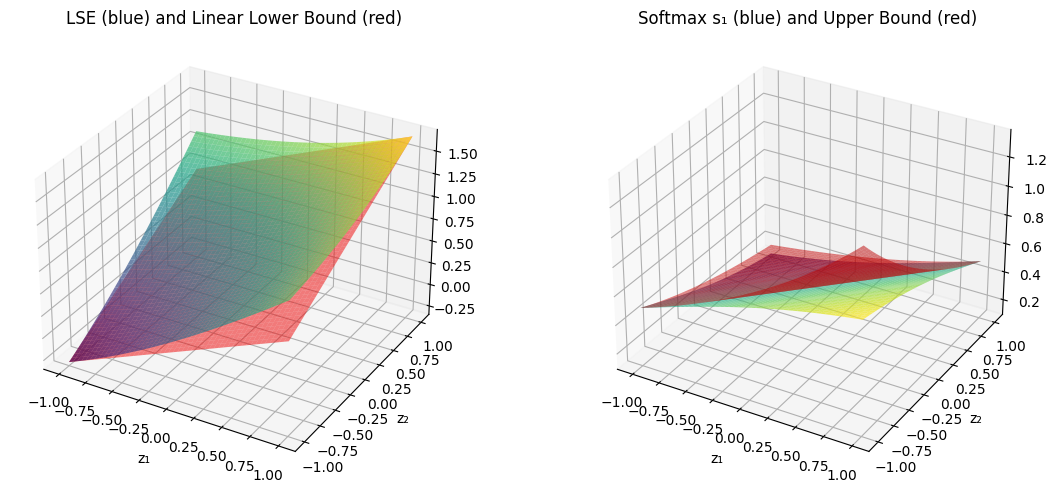

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 2D example for visualization
z_bounds = [(-1, 1), (-1, 1)]

# Create grid
z1 = np.linspace(-1, 1, 50)
z2 = np.linspace(-1, 1, 50)
Z1, Z2 = np.meshgrid(z1, z2)

# True LSE
LSE_true = np.zeros_like(Z1)
for i in range(len(z1)):
    for j in range(len(z2)):
        LSE_true[i, j] = lse(np.array([Z1[i, j], Z2[i, j]]))

# LSE lower bound (tangent at origin)
c0, coeffs = lse_tangent_lower_bound(np.array([0, 0]))
LSE_lower = c0 + coeffs[0] * Z1 + coeffs[1] * Z2

# Plot
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(Z1, Z2, LSE_true, alpha=0.7, cmap='viridis')
ax1.plot_surface(Z1, Z2, LSE_lower, alpha=0.5, color='red')
ax1.set_title('LSE (blue) and Linear Lower Bound (red)')
ax1.set_xlabel('z₁')
ax1.set_ylabel('z₂')

# True softmax component 1
S1_true = np.exp(Z1 - LSE_true)

# Upper bound on softmax from LSE lower bound
S1_upper = np.exp(Z1 - LSE_lower)

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(Z1, Z2, S1_true, alpha=0.7, cmap='viridis')
ax2.plot_surface(Z1, Z2, S1_upper, alpha=0.5, color='red')
ax2.set_title('Softmax s₁ (blue) and Upper Bound (red)')
ax2.set_xlabel('z₁')
ax2.set_ylabel('z₂')

plt.tight_layout()
plt.show()

In [3]:
import numpy as np
import itertools
from typing import List, Tuple
import matplotlib.pyplot as plt

# ============================================================
# CORE FUNCTIONS
# ============================================================

def lse(z):
    """Numerically stable Log-Sum-Exp."""
    z_max = np.max(z)
    return z_max + np.log(np.sum(np.exp(z - z_max)))

def softmax(z):
    """Numerically stable softmax."""
    z_shifted = z - np.max(z)
    exps = np.exp(z_shifted)
    return exps / np.sum(exps)

def lse_gradient(z):
    """Gradient of LSE is softmax."""
    return softmax(z)

# ============================================================
# LSE TANGENT PLANES (For Lower Bounds)
# ============================================================

def lse_tangent_lower_bound(z_point):
    """
    Creates a linear lower bound on LSE at point z_point.
    
    Since LSE is convex:
    LSE(z) ≥ LSE(z*) + ∇LSE(z*) · (z - z*)
    
    Returns: (c₀, [c₁, ..., cₖ]) such that
             LSE_lower(z) = c₀ + Σᵢ cᵢ·zᵢ
    """
    lse_val = lse(z_point)
    grad_lse = lse_gradient(z_point)
    
    # LSE_lower(z) = lse_val + grad · (z - z_point)
    #              = (lse_val - grad·z_point) + grad·z
    c0 = lse_val - np.dot(grad_lse, z_point)
    coeffs = grad_lse.copy()
    
    return c0, coeffs

def generate_lse_tangent_points(z_bounds, strategy='comprehensive'):
    """
    Generate strategic points for LSE tangent planes.
    
    Strategies:
    - 'center': Just the center point (1 tangent)
    - 'corners': All corners (2^K tangents)
    - 'comprehensive': Center + corners + face centers
    """
    K = len(z_bounds)
    points = []
    
    # Center point
    center = np.array([(l + u) / 2 for l, u in z_bounds])
    points.append(center)
    
    if strategy == 'center':
        return points
    
    # All corner points
    corners = list(itertools.product(*z_bounds))
    points.extend([np.array(c) for c in corners])
    
    if strategy == 'corners':
        return points
    
    # Face centers (one for each dimension, both sides)
    if strategy == 'comprehensive':
        for i in range(K):
            # Lower face
            p_low = center.copy()
            p_low[i] = z_bounds[i][0]
            points.append(p_low)
            
            # Upper face
            p_high = center.copy()
            p_high[i] = z_bounds[i][1]
            points.append(p_high)
    
    return points

def create_lse_lower_envelope(z_bounds, strategy='comprehensive'):
    """
    Creates multiple tangent planes to LSE for a tight lower bound.
    
    Returns: List of (c₀, coeffs) tuples
    """
    tangent_points = generate_lse_tangent_points(z_bounds, strategy)
    
    tangent_planes = []
    for z_point in tangent_points:
        c0, coeffs = lse_tangent_lower_bound(z_point)
        tangent_planes.append((c0, coeffs))
    
    return tangent_planes

# ============================================================
# LSE UPPER BOUNDS (Using Corners/Convex Hull)
# ============================================================

def create_lse_upper_bound_simple(z_bounds):
    """
    Simple LSE upper bound: maximum value at corners.
    
    Since LSE is convex, max over corners bounds it from above.
    Returns: constant value
    """
    corners = itertools.product(*z_bounds)
    lse_values = [lse(np.array(corner)) for corner in corners]
    return max(lse_values)

def create_lse_upper_bound_linear(z_bounds):
    """
    Better LSE upper bound: linear function through corners.
    
    Use convex hull upper envelope (chord/secant approximation).
    For simplicity, we'll use a chord through extreme corners.
    
    Returns: (c₀, coeffs) for linear upper bound
    """
    K = len(z_bounds)
    
    # Find two extreme corners for chord
    # Lower corner: all lower bounds
    z_lower = np.array([l for l, u in z_bounds])
    lse_lower = lse(z_lower)
    
    # Upper corner: all upper bounds
    z_upper = np.array([u for l, u in z_bounds])
    lse_upper = lse(z_upper)
    
    # Chord (secant line) between these two points
    # LSE(z) ≈ lse_lower + slope · (z - z_lower)
    
    direction = z_upper - z_lower
    if np.allclose(direction, 0):
        # Degenerate case
        return lse_lower, np.zeros(K)
    
    slope_value = (lse_upper - lse_lower) / np.linalg.norm(direction)
    normalized_dir = direction / np.linalg.norm(direction)
    
    # This is still an upper bound due to convexity
    # For a more precise upper bound, we'd need the full convex hull
    # For now, use conservative constant bound
    
    return create_lse_upper_bound_simple(z_bounds), None

# ============================================================
# LINEARIZE EXPONENTIAL FUNCTIONS
# ============================================================

def linearize_exp_over_interval(phi_min, phi_max, method='chord'):
    """
    Linearize exp(φ) over interval [phi_min, phi_max].
    
    Methods:
    - 'chord': Secant line (sound upper bound for convex exp)
    - 'tangent_lower': Tangent at phi_min (sound lower bound)
    - 'tangent_upper': Tangent at phi_max (sound lower bound)
    """
    if phi_max - phi_min < 1e-10:
        # Degenerate case
        return np.exp(phi_min), 0.0
    
    if method == 'chord':
        # exp(φ) ≤ intercept + slope·φ
        slope = (np.exp(phi_max) - np.exp(phi_min)) / (phi_max - phi_min)
        intercept = np.exp(phi_min) - slope * phi_min
        return intercept, slope
    
    elif method == 'tangent_lower':
        # Use tangent at phi_min
        # exp(φ) ≥ exp(φ_min)·(1 + φ - φ_min)
        exp_min = np.exp(phi_min)
        slope = exp_min
        intercept = exp_min * (1 - phi_min)
        return intercept, slope
    
    elif method == 'tangent_upper':
        # Use tangent at phi_max
        exp_max = np.exp(phi_max)
        slope = exp_max
        intercept = exp_max * (1 - phi_max)
        return intercept, slope

def bound_linear_function(coeffs, c0, z_bounds):
    """
    Bound a linear function f(z) = c₀ + Σᵢ cᵢ·zᵢ over box z_bounds.
    
    Returns: (f_min, f_max)
    """
    K = len(z_bounds)
    f_min = c0
    f_max = c0
    
    for i in range(K):
        if coeffs[i] >= 0:
            f_min += coeffs[i] * z_bounds[i][0]
            f_max += coeffs[i] * z_bounds[i][1]
        else:
            f_min += coeffs[i] * z_bounds[i][1]
            f_max += coeffs[i] * z_bounds[i][0]
    
    return f_min, f_max

# ============================================================
# SOFTMAX UPPER BOUNDS (from LSE Lower Bounds)
# ============================================================

def create_softmax_upper_from_lse_lower(output_idx, c0_lse, coeffs_lse, z_bounds):
    """
    Create linear upper bound on softmax component i.
    
    Given: LSE_lower(z) = c₀ + Σⱼ cⱼ·zⱼ
    We have: sᵢ(z) = exp(zᵢ - LSE(z)) ≤ exp(zᵢ - LSE_lower(z))
    
    Steps:
    1. Define φ(z) = zᵢ - LSE_lower(z) = zᵢ - c₀ - Σⱼ cⱼ·zⱼ
    2. Bound φ(z) over the box → [φ_min, φ_max]
    3. Linearize exp(φ) over [φ_min, φ_max] using chord
    4. Substitute back to get linear bound on sᵢ
    
    Returns: (c₀_upper, coeffs_upper) for sᵢ(z) ≤ c₀_upper + Σⱼ coeffs_upper[j]·zⱼ
    """
    K = len(z_bounds)
    i = output_idx
    
    # Step 1: φ(z) = zᵢ - c₀ - Σⱼ cⱼ·zⱼ
    #              = -c₀ + (1 - cᵢ)·zᵢ - Σⱼ≠ᵢ cⱼ·zⱼ
    
    phi_coeffs = np.zeros(K)
    phi_coeffs[i] = 1 - coeffs_lse[i]
    for j in range(K):
        if j != i:
            phi_coeffs[j] = -coeffs_lse[j]
    
    # Step 2: Bound φ(z)
    phi_min, phi_max = bound_linear_function(phi_coeffs, -c0_lse, z_bounds)
    
    # Step 3: Linearize exp(φ)
    # exp(φ) ≤ intercept + slope·φ
    intercept, slope = linearize_exp_over_interval(phi_min, phi_max, method='chord')
    
    # Step 4: Substitute back
    # sᵢ(z) ≤ exp(φ(z)) ≤ intercept + slope·φ(z)
    #                    = intercept + slope·(-c₀ + Σⱼ phi_coeffs[j]·zⱼ)
    #                    = (intercept - slope·c₀) + Σⱼ (slope·phi_coeffs[j])·zⱼ
    
    final_c0 = intercept + slope * (-c0_lse)
    final_coeffs = slope * phi_coeffs
    
    return final_c0, final_coeffs

# ============================================================
# SOFTMAX LOWER BOUNDS (from LSE Upper Bounds)
# ============================================================

def create_softmax_lower_from_lse_upper(output_idx, lse_upper_value, z_bounds):
    """
    Create linear lower bound on softmax component i.
    
    Given: LSE(z) ≤ lse_upper_value (constant)
    We have: sᵢ(z) = exp(zᵢ - LSE(z)) ≥ exp(zᵢ - lse_upper_value)
    
    Steps:
    1. Define φ(z) = zᵢ - lse_upper_value
    2. Bound φ(z) over the box → [φ_min, φ_max]
    3. Linearize exp(φ) from below using tangent
    
    Returns: (c₀_lower, coeffs_lower)
    """
    K = len(z_bounds)
    i = output_idx
    
    # Step 1: φ(z) = zᵢ - lse_upper_value
    phi_min = z_bounds[i][0] - lse_upper_value
    phi_max = z_bounds[i][1] - lse_upper_value
    
    # Step 2: Choose tangent point (use middle of interval for balance)
    phi_tangent = (phi_min + phi_max) / 2
    
    # Step 3: Tangent to exp at phi_tangent
    # exp(φ) ≥ exp(φ*) + exp(φ*)·(φ - φ*)
    #        = exp(φ*)·(1 - φ*) + exp(φ*)·φ
    
    exp_tangent = np.exp(phi_tangent)
    
    # sᵢ(z) ≥ exp_tangent·(1 - φ_tangent) + exp_tangent·(zᵢ - lse_upper_value)
    #        = exp_tangent·(1 - φ_tangent - lse_upper_value) + exp_tangent·zᵢ
    
    c0 = exp_tangent * (1 - phi_tangent - lse_upper_value)
    coeffs = np.zeros(K)
    coeffs[i] = exp_tangent
    
    return c0, coeffs

# ============================================================
# COMPLETE SOFTMAX BOUNDS
# ============================================================

def compute_softmax_bounds_lse(z_bounds, output_idx, strategy='comprehensive'):
    """
    Complete LSE-based softmax approximation.
    
    Args:
        z_bounds: List of (lower, upper) tuples for each input
        output_idx: Which softmax component to approximate
        strategy: 'center', 'corners', or 'comprehensive'
    
    Returns:
        lower_bound: (c₀, coeffs) for linear lower bound
        upper_bound: (c₀, coeffs) for linear upper bound
        metadata: Dictionary with intermediate results
    """
    K = len(z_bounds)
    i = output_idx
    
    metadata = {}
    
    # ===== UPPER BOUND =====
    # Step 1: Create LSE lower envelope (multiple tangents)
    lse_tangents = create_lse_lower_envelope(z_bounds, strategy)
    metadata['num_lse_tangents'] = len(lse_tangents)
    metadata['lse_tangents'] = lse_tangents
    
    # Step 2: Create softmax upper bound from each LSE tangent
    upper_candidates = []
    for c0_lse, coeffs_lse in lse_tangents:
        upper = create_softmax_upper_from_lse_lower(i, c0_lse, coeffs_lse, z_bounds)
        upper_candidates.append(upper)
    
    # Step 3: Choose tightest (evaluate at sample points)
    best_upper = choose_tightest_bound(upper_candidates, z_bounds, mode='min')
    metadata['upper_candidates_count'] = len(upper_candidates)
    
    # ===== LOWER BOUND =====
    # Step 1: Create LSE upper bound
    lse_upper = create_lse_upper_bound_simple(z_bounds)
    metadata['lse_upper'] = lse_upper
    
    # Step 2: Create softmax lower bound
    lower = create_softmax_lower_from_lse_upper(i, lse_upper, z_bounds)
    
    return lower, best_upper, metadata

def choose_tightest_bound(candidates, z_bounds, mode='min', num_samples=100):
    """
    Choose tightest bound by evaluating at random sample points.
    
    mode='min': Choose minimum (for upper bounds)
    mode='max': Choose maximum (for lower bounds)
    """
    K = len(z_bounds)
    
    # Generate sample points
    np.random.seed(42)  # Reproducible
    sample_points = []
    for _ in range(num_samples):
        point = np.array([np.random.uniform(l, u) for l, u in z_bounds])
        sample_points.append(point)
    
    best_candidate = None
    best_avg_value = float('inf') if mode == 'min' else float('-inf')
    
    for c0, coeffs in candidates:
        values = [c0 + np.dot(coeffs, point) for point in sample_points]
        avg_value = np.mean(values)
        
        if mode == 'min' and avg_value < best_avg_value:
            best_avg_value = avg_value
            best_candidate = (c0, coeffs)
        elif mode == 'max' and avg_value > best_avg_value:
            best_avg_value = avg_value
            best_candidate = (c0, coeffs)
    
    return best_candidate

# ============================================================
# VERIFICATION
# ============================================================

def verify_bounds_comprehensive(z_bounds, output_idx, lower_bound, upper_bound, 
                                num_samples=10000, verbose=True):
    """
    Comprehensive verification of computed bounds.
    """
    K = len(z_bounds)
    i = output_idx
    
    c0_lower, coeffs_lower = lower_bound
    c0_upper, coeffs_upper = upper_bound
    
    np.random.seed(42)
    
    violations_lower = 0
    violations_upper = 0
    max_violation_lower = 0
    max_violation_upper = 0
    
    gaps = []
    true_values = []
    lower_values = []
    upper_values = []
    
    for _ in range(num_samples):
        # Sample random point
        z = np.array([np.random.uniform(l, u) for l, u in z_bounds])
        
        # True softmax
        s_true = softmax(z)[i]
        true_values.append(s_true)
        
        # Computed bounds
        s_lower = c0_lower + np.dot(coeffs_lower, z)
        s_upper = c0_upper + np.dot(coeffs_upper, z)
        
        lower_values.append(s_lower)
        upper_values.append(s_upper)
        
        # Check violations
        tolerance = 1e-6
        if s_true < s_lower - tolerance:
            violations_lower += 1
            max_violation_lower = max(max_violation_lower, s_lower - s_true)
        
        if s_true > s_upper + tolerance:
            violations_upper += 1
            max_violation_upper = max(max_violation_upper, s_true - s_upper)
        
        # Track gap
        gap = s_upper - s_lower
        gaps.append(gap)
    
    # Statistics
    avg_gap = np.mean(gaps)
    max_gap = np.max(gaps)
    avg_tightness = 1 - (avg_gap / (np.max(true_values) - np.min(true_values)))
    
    if verbose:
        print(f"\n{'='*70}")
        print(f"VERIFICATION RESULTS (Component s_{i+1})")
        print(f"{'='*70}")
        print(f"Samples tested: {num_samples}")
        print(f"\nSoundness:")
        print(f"  Lower bound violations: {violations_lower} "
              f"({'✅ SOUND' if violations_lower == 0 else '❌ UNSOUND'})")
        if violations_lower > 0:
            print(f"    Max violation: {max_violation_lower:.6f}")
        
        print(f"  Upper bound violations: {violations_upper} "
              f"({'✅ SOUND' if violations_upper == 0 else '❌ UNSOUND'})")
        if violations_upper > 0:
            print(f"    Max violation: {max_violation_upper:.6f}")
        
        print(f"\nTightness:")
        print(f"  Average gap: {avg_gap:.6f}")
        print(f"  Maximum gap: {max_gap:.6f}")
        print(f"  Relative tightness: {avg_tightness*100:.1f}%")
        print(f"\nValue ranges:")
        print(f"  True softmax: [{np.min(true_values):.6f}, {np.max(true_values):.6f}]")
        print(f"  Lower bounds: [{np.min(lower_values):.6f}, {np.max(lower_values):.6f}]")
        print(f"  Upper bounds: [{np.min(upper_values):.6f}, {np.max(upper_values):.6f}]")
        print(f"{'='*70}\n")
    
    return {
        'violations_lower': violations_lower,
        'violations_upper': violations_upper,
        'avg_gap': avg_gap,
        'max_gap': max_gap,
        'tightness': avg_tightness,
        'sound': violations_lower == 0 and violations_upper == 0
    }

# ============================================================
# VISUALIZATION
# ============================================================

def visualize_bounds_2d_slice(z_bounds, output_idx, lower_bound, upper_bound,
                              slice_dims=(0, 1)):
    """
    Visualize bounds by taking a 2D slice through the high-dimensional space.
    """
    K = len(z_bounds)
    i = output_idx
    dim1, dim2 = slice_dims
    
    # Fix other dimensions at center
    z_fixed = np.array([(l + u) / 2 for l, u in z_bounds])
    
    # Create grid for the two dimensions
    n_points = 50
    z1_vals = np.linspace(z_bounds[dim1][0], z_bounds[dim1][1], n_points)
    z2_vals = np.linspace(z_bounds[dim2][0], z_bounds[dim2][1], n_points)
    Z1, Z2 = np.meshgrid(z1_vals, z2_vals)
    
    # Evaluate functions
    S_true = np.zeros_like(Z1)
    S_lower = np.zeros_like(Z1)
    S_upper = np.zeros_like(Z1)
    
    c0_lower, coeffs_lower = lower_bound
    c0_upper, coeffs_upper = upper_bound
    
    for idx1 in range(n_points):
        for idx2 in range(n_points):
            z = z_fixed.copy()
            z[dim1] = Z1[idx1, idx2]
            z[dim2] = Z2[idx1, idx2]
            
            S_true[idx1, idx2] = softmax(z)[i]
            S_lower[idx1, idx2] = c0_lower + np.dot(coeffs_lower, z)
            S_upper[idx1, idx2] = c0_upper + np.dot(coeffs_upper, z)
    
    # Plot
    fig = plt.figure(figsize=(15, 5))
    
    # 3D surface plot
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot_surface(Z1, Z2, S_true, alpha=0.6, cmap='viridis', label='True')
    ax1.plot_surface(Z1, Z2, S_lower, alpha=0.4, color='blue')
    ax1.plot_surface(Z1, Z2, S_upper, alpha=0.4, color='red')
    ax1.set_xlabel(f'z_{dim1+1}')
    ax1.set_ylabel(f'z_{dim2+1}')
    ax1.set_zlabel(f's_{i+1}')
    ax1.set_title('Softmax and Bounds (3D)')
    
    # Contour plot
    ax2 = fig.add_subplot(132)
    levels = np.linspace(np.min(S_true), np.max(S_true), 15)
    ax2.contour(Z1, Z2, S_true, levels=levels, colors='green', linewidths=2)
    ax2.contour(Z1, Z2, S_lower, levels=levels, colors='blue', linewidths=1, linestyles='--')
    ax2.contour(Z1, Z2, S_upper, levels=levels, colors='red', linewidths=1, linestyles='--')
    ax2.set_xlabel(f'z_{dim1+1}')
    ax2.set_ylabel(f'z_{dim2+1}')
    ax2.set_title('Contour Plot')
    ax2.grid(True, alpha=0.3)
    
    # Gap visualization
    ax3 = fig.add_subplot(133)
    gap = S_upper - S_lower
    im = ax3.contourf(Z1, Z2, gap, levels=20, cmap='RdYlGn_r')
    ax3.set_xlabel(f'z_{dim1+1}')
    ax3.set_ylabel(f'z_{dim2+1}')
    ax3.set_title('Approximation Gap (Upper - Lower)')
    plt.colorbar(im, ax=ax3)
    
    plt.tight_layout()
    plt.show()


LSE-BASED SOFTMAX APPROXIMATION: 5-Input Example

Input Logit Box:
  z_1: [2.00, 3.00]
  z_2: [2.50, 3.50]
  z_3: [0.00, 1.00]
  z_4: [-1.00, 0.00]
  z_5: [-2.00, -1.00]

----------------------------------------------------------------------
COMPONENT s_1
----------------------------------------------------------------------

Strategy: CENTER
  LSE tangent planes used: 1
  Upper bound candidates: 1
  Soundness: ✅ SOUND
  Average gap: 0.216020
  Tightness: 47.8%

Strategy: CORNERS
  LSE tangent planes used: 33
  Upper bound candidates: 33
  Soundness: ✅ SOUND
  Average gap: 0.216020
  Tightness: 47.8%

Strategy: COMPREHENSIVE
  LSE tangent planes used: 43
  Upper bound candidates: 43
  Soundness: ✅ SOUND
  Average gap: 0.201790
  Tightness: 51.2%

----------------------------------------------------------------------
COMPONENT s_2
----------------------------------------------------------------------

Strategy: CENTER
  LSE tangent planes used: 1
  Upper bound candidates: 1
  Soundness

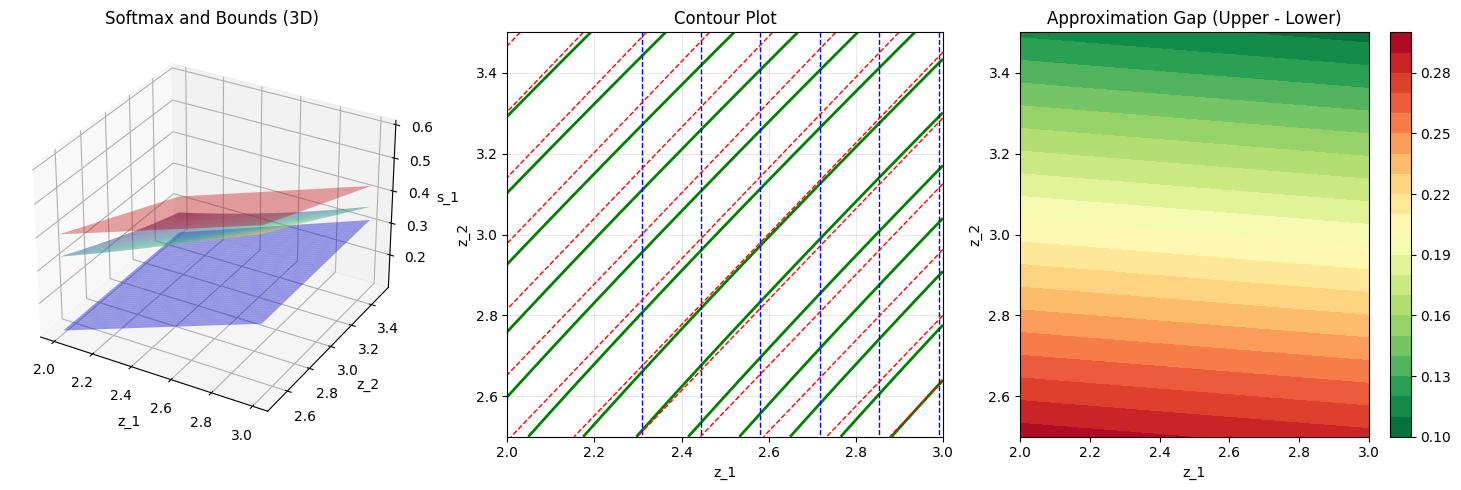


FINAL LINEAR CONSTRAINTS for s_1

Lower bound:
  s_1 ≥ -0.318985 + 0.212657·z_1 + 0.000000·z_2 + 0.000000·z_3 + 0.000000·z_4 + 0.000000·z_5

Upper bound:
  s_1 ≤ 0.449064 + 0.200291·z_1 - 0.178292·z_2 - 0.014635·z_3 - 0.005384·z_4 - 0.001981·z_5



FINAL LINEAR CONSTRAINTS for s_2

Lower bound:
  s_2 ≥ -0.701223 + 0.000000·z_1 + 0.350612·z_2 + 0.000000·z_3 + 0.000000·z_4 + 0.000000·z_5

Upper bound:
  s_2 ≤ 0.454131 - 0.153993·z_1 + 0.185321·z_2 - 0.020841·z_3 - 0.007667·z_4 - 0.002820·z_5



FINAL LINEAR CONSTRAINTS for s_3

Lower bound:
  s_3 ≥ 0.014390 + 0.000000·z_1 + 0.000000·z_2 + 0.028780·z_3 + 0.000000·z_4 + 0.000000·z_5

Upper bound:
  s_3 ≤ 0.182459 - 0.018679·z_1 - 0.030796·z_2 + 0.050747·z_3 - 0.000930·z_4 - 0.000342·z_5



FINAL LINEAR CONSTRAINTS for s_4

Lower bound:
  s_4 ≥ 0.015881 + 0.000000·z_1 + 0.000000·z_2 + 0.000000·z_3 + 0.010588·z_4 + 0.000000·z_5

Upper bound:
  s_4 ≤ 0.089282 - 0.007071·z_1 - 0.011658·z_2 - 0.000957·z_3 + 0.019815·z_4 - 0.000130·z_5




In [6]:
np.random.seed(42)
print("\n" + "="*70)
print("LSE-BASED SOFTMAX APPROXIMATION: 5-Input Example")
print("="*70)

# Define 5-input logit box (competitive regime)
z_bounds = [
    (2.0, 3.0),    # z₁
    (2.5, 3.5),    # z₂
    (0.0, 1.0),    # z₃
    (-1.0, 0.0),   # z₄
    (-2.0, -1.0),  # z₅
]

print("\nInput Logit Box:")
for i, (l, u) in enumerate(z_bounds):
    print(f"  z_{i+1}: [{l:.2f}, {u:.2f}]")

# Compute bounds for each softmax component
all_results = []

for output_idx in range(5):
    print(f"\n{'-'*70}")
    print(f"COMPONENT s_{output_idx + 1}")
    print(f"{'-'*70}")
    
    # Compute bounds with different strategies
    for strategy in ['center', 'corners', 'comprehensive']:
        print(f"\nStrategy: {strategy.upper()}")
        
        lower, upper, metadata = compute_softmax_bounds_lse(
            z_bounds, output_idx, strategy
        )
        
        print(f"  LSE tangent planes used: {metadata['num_lse_tangents']}")
        print(f"  Upper bound candidates: {metadata['upper_candidates_count']}")
        
        # Verify
        results = verify_bounds_comprehensive(
            z_bounds, output_idx, lower, upper,
            num_samples=10000, verbose=False
        )
        
        print(f"  Soundness: {'✅ SOUND' if results['sound'] else '❌ UNSOUND'}")
        print(f"  Average gap: {results['avg_gap']:.6f}")
        print(f"  Tightness: {results['tightness']*100:.1f}%")
        
        if strategy == 'comprehensive':
            all_results.append({
                'component': output_idx,
                'lower': lower,
                'upper': upper,
                'metadata': metadata,
                'verification': results
            })

# Summary comparison
print(f"\n{'='*70}")
print("SUMMARY: All Components with 'comprehensive' Strategy")
print(f"{'='*70}")
print(f"{'Component':<12} {'Avg Gap':<12} {'Tightness':<12} {'Sound':<10}")
print("-"*70)

for res in all_results:
    comp = res['component']
    gap = res['verification']['avg_gap']
    tight = res['verification']['tightness']
    sound = '✅' if res['verification']['sound'] else '❌'
    print(f"s_{comp+1:<11} {gap:<12.6f} {tight*100:<11.1f}% {sound:<10}")

# Visualize one component (2D slice)
print(f"\n{'='*70}")
print("VISUALIZATION: Component s_1 (2D slice: z₁ vs z₂)")
print(f"{'='*70}")

visualize_bounds_2d_slice(
    z_bounds, 
    output_idx=0,
    lower_bound=all_results[0]['lower'],
    upper_bound=all_results[0]['upper'],
    slice_dims=(0, 1)
)

# Print actual linear constraints
print(f"\n{'='*70}")
print("FINAL LINEAR CONSTRAINTS for s_1")
print(f"{'='*70}")

c0_lower, coeffs_lower = all_results[0]['lower']
c0_upper, coeffs_upper = all_results[0]['upper']

print("\nLower bound:")
print(f"  s_1 ≥ {c0_lower:.6f}", end="")
for i, coeff in enumerate(coeffs_lower):
    sign = "+" if coeff >= 0 else "-"
    print(f" {sign} {abs(coeff):.6f}·z_{i+1}", end="")
print()

print("\nUpper bound:")
print(f"  s_1 ≤ {c0_upper:.6f}", end="")
for i, coeff in enumerate(coeffs_upper):
    sign = "+" if coeff >= 0 else "-"
    print(f" {sign} {abs(coeff):.6f}·z_{i+1}", end="")
print()

print(f"\n{'='*70}\n")

# Print actual linear constraints
print(f"\n{'='*70}")
print("FINAL LINEAR CONSTRAINTS for s_2")
print(f"{'='*70}")

c0_lower, coeffs_lower = all_results[1]['lower']
c0_upper, coeffs_upper = all_results[1]['upper']

print("\nLower bound:")
print(f"  s_2 ≥ {c0_lower:.6f}", end="")
for i, coeff in enumerate(coeffs_lower):
    sign = "+" if coeff >= 0 else "-"
    print(f" {sign} {abs(coeff):.6f}·z_{i+1}", end="")
print()

print("\nUpper bound:")
print(f"  s_2 ≤ {c0_upper:.6f}", end="")
for i, coeff in enumerate(coeffs_upper):
    sign = "+" if coeff >= 0 else "-"
    print(f" {sign} {abs(coeff):.6f}·z_{i+1}", end="")
print()

print(f"\n{'='*70}\n")

# Print actual linear constraints
print(f"\n{'='*70}")
print("FINAL LINEAR CONSTRAINTS for s_3")
print(f"{'='*70}")

c0_lower, coeffs_lower = all_results[2]['lower']
c0_upper, coeffs_upper = all_results[2]['upper']

print("\nLower bound:")
print(f"  s_3 ≥ {c0_lower:.6f}", end="")
for i, coeff in enumerate(coeffs_lower):
    sign = "+" if coeff >= 0 else "-"
    print(f" {sign} {abs(coeff):.6f}·z_{i+1}", end="")
print()

print("\nUpper bound:")
print(f"  s_3 ≤ {c0_upper:.6f}", end="")
for i, coeff in enumerate(coeffs_upper):
    sign = "+" if coeff >= 0 else "-"
    print(f" {sign} {abs(coeff):.6f}·z_{i+1}", end="")
print()

print(f"\n{'='*70}\n")

# Print actual linear constraints
print(f"\n{'='*70}")
print("FINAL LINEAR CONSTRAINTS for s_4")
print(f"{'='*70}")

c0_lower, coeffs_lower = all_results[3]['lower']
c0_upper, coeffs_upper = all_results[3]['upper']

print("\nLower bound:")
print(f"  s_4 ≥ {c0_lower:.6f}", end="")
for i, coeff in enumerate(coeffs_lower):
    sign = "+" if coeff >= 0 else "-"
    print(f" {sign} {abs(coeff):.6f}·z_{i+1}", end="")
print()

print("\nUpper bound:")
print(f"  s_4 ≤ {c0_upper:.6f}", end="")
for i, coeff in enumerate(coeffs_upper):
    sign = "+" if coeff >= 0 else "-"
    print(f" {sign} {abs(coeff):.6f}·z_{i+1}", end="")
print()

print(f"\n{'='*70}\n")

In [7]:
import numpy as np
import itertools
from scipy.spatial import ConvexHull
from scipy.optimize import linprog

# ============================================================
# FIXED: LINEAR LSE UPPER BOUND
# ============================================================

def create_lse_upper_bound_convex_hull(z_bounds):
    """
    Creates a LINEAR upper bound on LSE using convex hull.
    
    Since LSE is convex, any hyperplane that passes above all corners
    is a valid upper bound. We find the tightest such hyperplane.
    
    Returns: (d_0, [d_1, ..., d_K]) such that
             LSE(z) ≤ d_0 + Σd_j·z_j
    """
    K = len(z_bounds)
    
    # Get all corner points
    corners = list(itertools.product(*z_bounds))
    n_corners = len(corners)
    
    # Evaluate LSE at all corners
    lse_values = np.array([lse(np.array(corner)) for corner in corners])
    
    # Method 1: Fit hyperplane through corners using least squares
    # This ensures it's above all corners (with small safety margin)
    
    # Build matrix A where each row is [z_1, z_2, ..., z_K, 1]
    A = np.column_stack([corners, np.ones(n_corners)])
    
    # Solve: A @ [d_1, d_2, ..., d_K, d_0]^T ≈ lse_values
    # But ensure it's an UPPER bound (all residuals ≤ 0)
    
    # Use least squares
    coeffs_with_bias = np.linalg.lstsq(A, lse_values, rcond=None)[0]
    
    d_coeffs = coeffs_with_bias[:-1]  # d_1, ..., d_K
    d_0 = coeffs_with_bias[-1]
    
    # Check if this is a valid upper bound, if not, add safety margin
    max_violation = 0.0
    for corner, lse_val in zip(corners, lse_values):
        approx = d_0 + np.dot(d_coeffs, corner)
        if approx < lse_val:
            max_violation = max(max_violation, lse_val - approx)
    
    # Add safety margin
    d_0_safe = d_0 + max_violation + 1e-6
    
    return d_0_safe, d_coeffs


def create_lse_upper_bound_tangent_based(z_bounds, strategy='maximum_gradient'):
    """
    Alternative: Create LSE upper bound using tangent plane at strategic point.
    
    For a convex function, the tangent at ANY point is a global LOWER bound.
    But we want an UPPER bound, so we use the tangent at the point where
    the gradient is largest (steepest direction).
    
    Actually, this won't work directly. For upper bounds on convex functions,
    we need chords/secants, not tangents.
    
    Let's use the convex hull method instead.
    """
    return create_lse_upper_bound_convex_hull(z_bounds)


def create_lse_upper_bound_optimized(z_bounds):
    """
    Optimized approach: Find the tightest linear upper bound.
    
    Formulation as linear program:
    Minimize: average value of (d_0 + Σd_j·z_j) over sample points
    Subject to: d_0 + Σd_j·z_j ≥ LSE(corner) for all corners
    
    This gives the tightest linear upper bound.
    """
    K = len(z_bounds)
    
    # Get corners
    corners = list(itertools.product(*z_bounds))
    n_corners = len(corners)
    lse_values = [lse(np.array(corner)) for corner in corners]
    
    # Sample points for objective (minimize average value)
    n_samples = 100
    sample_points = []
    for _ in range(n_samples):
        point = [np.random.uniform(l, u) for l, u in z_bounds]
        sample_points.append(point)
    
    # Variables: [d_1, d_2, ..., d_K, d_0]
    # Objective: minimize average of (d_0 + Σd_j·z_j) over samples
    c = np.zeros(K + 1)
    for point in sample_points:
        c[:K] += np.array(point) / n_samples
    c[K] = 1.0  # d_0 coefficient
    
    # Constraints: d_0 + Σd_j·corner_j ≥ LSE(corner) for all corners
    # Rewrite as: -d_0 - Σd_j·corner_j ≤ -LSE(corner)
    A_ub = np.zeros((n_corners, K + 1))
    b_ub = np.zeros(n_corners)
    
    for idx, (corner, lse_val) in enumerate(zip(corners, lse_values)):
        A_ub[idx, :K] = -np.array(corner)
        A_ub[idx, K] = -1.0
        b_ub[idx] = -lse_val
    
    # Solve linear program
    result = linprog(c, A_ub=A_ub, b_ub=b_ub, method='highs')
    
    if result.success:
        d_coeffs = result.x[:K]
        d_0 = result.x[K]
        return d_0, d_coeffs
    else:
        # Fallback to least squares method
        print("LP solver failed, using fallback method")
        return create_lse_upper_bound_convex_hull(z_bounds)


# ============================================================
# FIXED: SOFTMAX LOWER BOUND WITH LINEAR LSE UPPER
# ============================================================

def create_softmax_lower_from_lse_upper_linear(output_idx, d_0, d_coeffs, z_bounds):
    """
    Create linear lower bound on softmax component i.
    
    Given: LSE(z) ≤ d_0 + Σⱼ d_j·z_j  (linear upper bound)
    We have: s_i(z) = exp(z_i - LSE(z)) ≥ exp(z_i - (d_0 + Σⱼ d_j·z_j))
    
    Define: φ(z) = z_i - d_0 - Σⱼ d_j·z_j
                 = -d_0 + (1 - d_i)·z_i - Σⱼ≠ᵢ d_j·z_j
    
    Then: s_i(z) ≥ exp(φ(z))
    
    Linearize exp(φ) using tangent plane at a strategic point.
    
    Returns: (c_0, coeffs) for s_i(z) ≥ c_0 + Σⱼ coeffs[j]·z_j
    """
    K = len(z_bounds)
    i = output_idx
    
    # φ(z) = -d_0 + (1 - d_i)·z_i - Σⱼ≠ᵢ d_j·z_j
    phi_coeffs = np.zeros(K)
    phi_coeffs[i] = 1 - d_coeffs[i]
    for j in range(K):
        if j != i:
            phi_coeffs[j] = -d_coeffs[j]
    
    # Bound φ over the box
    phi_min, phi_max = bound_linear_function(phi_coeffs, -d_0, z_bounds)
    
    # Choose tangent point: use center of φ range for better approximation
    phi_tangent = (phi_min + phi_max) / 2
    
    # Could also use multiple tangent points and choose tightest
    # For now, use single tangent at midpoint
    
    # Tangent to exp(φ) at φ_tangent:
    # exp(φ) ≥ exp(φ*) + exp(φ*)·(φ - φ*)
    #        = exp(φ*)·(1 - φ*) + exp(φ*)·φ
    
    exp_val = np.exp(phi_tangent)
    
    # s_i(z) ≥ exp_val·(1 - φ_tangent) + exp_val·φ(z)
    #        = exp_val·(1 - φ_tangent) + exp_val·(-d_0 + Σⱼ phi_coeffs[j]·z_j)
    #        = exp_val·(1 - φ_tangent - d_0) + Σⱼ (exp_val·phi_coeffs[j])·z_j
    
    c0 = exp_val * (1 - phi_tangent - d_0)
    coeffs = exp_val * phi_coeffs
    
    return c0, coeffs


def create_softmax_lower_multiple_tangents(output_idx, d_0, d_coeffs, z_bounds):
    """
    Better: Create multiple tangent planes and choose tightest.
    """
    K = len(z_bounds)
    i = output_idx
    
    # φ(z) = -d_0 + (1 - d_i)·z_i - Σⱼ≠ᵢ d_j·z_j
    phi_coeffs = np.zeros(K)
    phi_coeffs[i] = 1 - d_coeffs[i]
    for j in range(K):
        if j != i:
            phi_coeffs[j] = -d_coeffs[j]
    
    phi_min, phi_max = bound_linear_function(phi_coeffs, -d_0, z_bounds)
    
    # Create tangents at multiple points in [phi_min, phi_max]
    tangent_points = [
        phi_min,
        phi_min + 0.25 * (phi_max - phi_min),
        phi_min + 0.5 * (phi_max - phi_min),
        phi_min + 0.75 * (phi_max - phi_min),
        phi_max,
    ]
    
    candidates = []
    for phi_tangent in tangent_points:
        exp_val = np.exp(phi_tangent)
        c0 = exp_val * (1 - phi_tangent - d_0)
        coeffs = exp_val * phi_coeffs
        candidates.append((c0, coeffs))
    
    # Choose tightest (maximum lower bound)
    best = choose_tightest_bound(candidates, z_bounds, mode='max')
    return best


# ============================================================
# UPDATED: COMPLETE SOFTMAX BOUNDS WITH FIXED LOWER BOUND
# ============================================================

def compute_softmax_bounds_lse_fixed(z_bounds, output_idx, strategy='comprehensive'):
    """
    Complete LSE-based softmax approximation with FIXED lower bounds.
    
    Key improvement: Uses LINEAR LSE upper bound instead of constant.
    This makes all variables appear in the lower bound!
    
    Args:
        z_bounds: List of (lower, upper) tuples
        output_idx: Which softmax component
        strategy: 'center', 'corners', or 'comprehensive'
    
    Returns:
        lower_bound: (c_0, coeffs) - NOW HAS NON-ZERO COEFFICIENTS!
        upper_bound: (c_0, coeffs)
        metadata: Dictionary with results
    """
    K = len(z_bounds)
    i = output_idx
    
    metadata = {}
    
    # ===== UPPER BOUND (unchanged) =====
    lse_tangents = create_lse_lower_envelope(z_bounds, strategy)
    metadata['num_lse_tangents'] = len(lse_tangents)
    
    upper_candidates = []
    for c0_lse, coeffs_lse in lse_tangents:
        upper = create_softmax_upper_from_lse_lower(i, c0_lse, coeffs_lse, z_bounds)
        upper_candidates.append(upper)
    
    best_upper = choose_tightest_bound(upper_candidates, z_bounds, mode='min')
    
    # ===== LOWER BOUND (FIXED!) =====
    # Use LINEAR LSE upper bound
    lse_upper_d0, lse_upper_coeffs = create_lse_upper_bound_optimized(z_bounds)
    metadata['lse_upper_d0'] = lse_upper_d0
    metadata['lse_upper_coeffs'] = lse_upper_coeffs
    
    # Create softmax lower bound with multiple tangents
    lower = create_softmax_lower_multiple_tangents(
        i, lse_upper_d0, lse_upper_coeffs, z_bounds
    )
    
    return lower, best_upper, metadata


# ============================================================
# HELPER FUNCTIONS (from previous code)
# ============================================================

def lse(z):
    """Numerically stable Log-Sum-Exp."""
    z_max = np.max(z)
    return z_max + np.log(np.sum(np.exp(z - z_max)))

def softmax(z):
    """Numerically stable softmax."""
    z_shifted = z - np.max(z)
    exps = np.exp(z_shifted)
    return exps / np.sum(exps)

def lse_gradient(z):
    """Gradient of LSE is softmax."""
    return softmax(z)

def lse_tangent_lower_bound(z_point):
    """Creates tangent plane to LSE."""
    lse_val = lse(z_point)
    grad_lse = lse_gradient(z_point)
    c0 = lse_val - np.dot(grad_lse, z_point)
    coeffs = grad_lse.copy()
    return c0, coeffs

def generate_lse_tangent_points(z_bounds, strategy='comprehensive'):
    """Generate points for LSE tangent planes."""
    K = len(z_bounds)
    points = []
    center = np.array([(l + u) / 2 for l, u in z_bounds])
    points.append(center)
    
    if strategy == 'center':
        return points
    
    corners = list(itertools.product(*z_bounds))
    points.extend([np.array(c) for c in corners])
    
    if strategy == 'corners':
        return points
    
    if strategy == 'comprehensive':
        for i in range(K):
            p_low = center.copy()
            p_low[i] = z_bounds[i][0]
            points.append(p_low)
            p_high = center.copy()
            p_high[i] = z_bounds[i][1]
            points.append(p_high)
    
    return points

def create_lse_lower_envelope(z_bounds, strategy='comprehensive'):
    """Creates multiple tangent planes to LSE."""
    tangent_points = generate_lse_tangent_points(z_bounds, strategy)
    tangent_planes = []
    for z_point in tangent_points:
        c0, coeffs = lse_tangent_lower_bound(z_point)
        tangent_planes.append((c0, coeffs))
    return tangent_planes

def bound_linear_function(coeffs, c0, z_bounds):
    """Bound linear function over box."""
    K = len(z_bounds)
    f_min = c0
    f_max = c0
    for i in range(K):
        if coeffs[i] >= 0:
            f_min += coeffs[i] * z_bounds[i][0]
            f_max += coeffs[i] * z_bounds[i][1]
        else:
            f_min += coeffs[i] * z_bounds[i][1]
            f_max += coeffs[i] * z_bounds[i][0]
    return f_min, f_max

def linearize_exp_over_interval(phi_min, phi_max, method='chord'):
    """Linearize exp over interval."""
    if phi_max - phi_min < 1e-10:
        return np.exp(phi_min), 0.0
    
    if method == 'chord':
        slope = (np.exp(phi_max) - np.exp(phi_min)) / (phi_max - phi_min)
        intercept = np.exp(phi_min) - slope * phi_min
        return intercept, slope

def create_softmax_upper_from_lse_lower(output_idx, c0_lse, coeffs_lse, z_bounds):
    """Create upper bound from LSE lower bound."""
    K = len(z_bounds)
    i = output_idx
    
    phi_coeffs = np.zeros(K)
    phi_coeffs[i] = 1 - coeffs_lse[i]
    for j in range(K):
        if j != i:
            phi_coeffs[j] = -coeffs_lse[j]
    
    phi_min, phi_max = bound_linear_function(phi_coeffs, -c0_lse, z_bounds)
    intercept, slope = linearize_exp_over_interval(phi_min, phi_max, method='chord')
    
    final_c0 = intercept + slope * (-c0_lse)
    final_coeffs = slope * phi_coeffs
    
    return final_c0, final_coeffs

def choose_tightest_bound(candidates, z_bounds, mode='min', num_samples=100):
    """Choose tightest bound."""
    K = len(z_bounds)
    np.random.seed(42)
    
    sample_points = []
    for _ in range(num_samples):
        point = np.array([np.random.uniform(l, u) for l, u in z_bounds])
        sample_points.append(point)
    
    best_candidate = None
    best_avg_value = float('inf') if mode == 'min' else float('-inf')
    
    for c0, coeffs in candidates:
        values = [c0 + np.dot(coeffs, point) for point in sample_points]
        avg_value = np.mean(values)
        
        if mode == 'min' and avg_value < best_avg_value:
            best_avg_value = avg_value
            best_candidate = (c0, coeffs)
        elif mode == 'max' and avg_value > best_avg_value:
            best_avg_value = avg_value
            best_candidate = (c0, coeffs)
    
    return best_candidate

def verify_bounds_comprehensive(z_bounds, output_idx, lower_bound, upper_bound, 
                                num_samples=10000, verbose=True):
    """Verify bounds."""
    K = len(z_bounds)
    i = output_idx
    
    c0_lower, coeffs_lower = lower_bound
    c0_upper, coeffs_upper = upper_bound
    
    np.random.seed(42)
    
    violations_lower = 0
    violations_upper = 0
    gaps = []
    
    for _ in range(num_samples):
        z = np.array([np.random.uniform(l, u) for l, u in z_bounds])
        s_true = softmax(z)[i]
        s_lower = c0_lower + np.dot(coeffs_lower, z)
        s_upper = c0_upper + np.dot(coeffs_upper, z)
        
        tolerance = 1e-6
        if s_true < s_lower - tolerance:
            violations_lower += 1
        if s_true > s_upper + tolerance:
            violations_upper += 1
        
        gaps.append(s_upper - s_lower)
    
    avg_gap = np.mean(gaps)
    
    if verbose:
        print(f"\nVerification (Component s_{i+1}):")
        print(f"  Lower violations: {violations_lower} "
              f"({'✅' if violations_lower == 0 else '❌'})")
        print(f"  Upper violations: {violations_upper} "
              f"({'✅' if violations_upper == 0 else '❌'})")
        print(f"  Average gap: {avg_gap:.6f}")
    
    return {
        'violations_lower': violations_lower,
        'violations_upper': violations_upper,
        'avg_gap': avg_gap,
        'sound': violations_lower == 0 and violations_upper == 0
    }


# ============================================================
# DEMONSTRATION
# ============================================================

def demonstrate_fix():
    """Show the fix in action."""
    print("="*70)
    print("DEMONSTRATION: Fixed Lower Bound")
    print("="*70)
    
    # Same 5-input example
    z_bounds = [
        (2.0, 3.0),
        (2.5, 3.5),
        (0.0, 1.0),
        (-1.0, 0.0),
        (-2.0, -1.0),
    ]
    
    print("\nInput box:")
    for i, (l, u) in enumerate(z_bounds):
        print(f"  z_{i+1}: [{l:.2f}, {u:.2f}]")
    
    # Component 1
    output_idx = 0
    
    print(f"\n{'='*70}")
    print("BEFORE FIX (constant LSE upper bound):")
    print(f"{'='*70}")
    
    # Old method
    from scipy.spatial import ConvexHull
    
    lse_upper_constant = create_lse_upper_bound_simple(z_bounds)
    print(f"\nLSE upper bound: {lse_upper_constant:.6f} (constant)")
    
    lower_old, _, _ = compute_softmax_bounds_lse(z_bounds, output_idx, 'comprehensive')
    c0, coeffs = lower_old
    
    print(f"\nLower bound constraint:")
    print(f"  s_1 ≥ {c0:.6f}", end="")
    for i, coeff in enumerate(coeffs):
        if abs(coeff) > 1e-6:
            sign = "+" if coeff >= 0 else "-"
            print(f" {sign} {abs(coeff):.6f}·z_{i+1}", end="")
    print()
    
    non_zero_count_old = np.sum(np.abs(coeffs) > 1e-6)
    print(f"\nNon-zero coefficients: {non_zero_count_old}/{len(coeffs)}")
    
    print(f"\n{'='*70}")
    print("AFTER FIX (linear LSE upper bound):")
    print(f"{'='*70}")
    
    # New method
    lower_new, upper_new, metadata = compute_softmax_bounds_lse_fixed(
        z_bounds, output_idx, 'comprehensive'
    )
    
    d0 = metadata['lse_upper_d0']
    d_coeffs = metadata['lse_upper_coeffs']
    
    print(f"\nLSE upper bound:")
    print(f"  LSE(z) ≤ {d0:.6f}", end="")
    for i, coeff in enumerate(d_coeffs):
        sign = "+" if coeff >= 0 else "-"
        print(f" {sign} {abs(coeff):.6f}·z_{i+1}", end="")
    print(" (linear!)")
    
    c0_new, coeffs_new = lower_new
    
    print(f"\nLower bound constraint:")
    print(f"  s_1 ≥ {c0_new:.6f}", end="")
    for i, coeff in enumerate(coeffs_new):
        if abs(coeff) > 1e-6:
            sign = "+" if coeff >= 0 else "-"
            print(f" {sign} {abs(coeff):.6f}·z_{i+1}", end="")
    print()
    
    non_zero_count_new = np.sum(np.abs(coeffs_new) > 1e-6)
    print(f"\nNon-zero coefficients: {non_zero_count_new}/{len(coeffs_new)} ✅")
    
    # Verify both
    print(f"\n{'='*70}")
    print("VERIFICATION:")
    print(f"{'='*70}")
    
    print("\nOld method:")
    results_old = verify_bounds_comprehensive(
        z_bounds, output_idx, lower_old, upper_new, 
        num_samples=10000, verbose=True
    )
    
    print("\nNew method:")
    results_new = verify_bounds_comprehensive(
        z_bounds, output_idx, lower_new, upper_new,
        num_samples=10000, verbose=True
    )
    
    print(f"\n{'='*70}")
    print("IMPROVEMENT:")
    print(f"{'='*70}")
    print(f"Gap reduction: {results_old['avg_gap']:.6f} → {results_new['avg_gap']:.6f}")
    improvement = (results_old['avg_gap'] - results_new['avg_gap']) / results_old['avg_gap'] * 100
    print(f"Improvement: {improvement:.1f}%")
    
    print(f"\n{'='*70}\n")


def create_lse_upper_bound_simple(z_bounds):
    """Simple constant upper bound (old method)."""
    corners = itertools.product(*z_bounds)
    lse_values = [lse(np.array(corner)) for corner in corners]
    return max(lse_values)

def compute_softmax_bounds_lse(z_bounds, output_idx, strategy):
    """Old method for comparison."""
    K = len(z_bounds)
    i = output_idx
    
    lse_tangents = create_lse_lower_envelope(z_bounds, strategy)
    
    upper_candidates = []
    for c0_lse, coeffs_lse in lse_tangents:
        upper = create_softmax_upper_from_lse_lower(i, c0_lse, coeffs_lse, z_bounds)
        upper_candidates.append(upper)
    
    best_upper = choose_tightest_bound(upper_candidates, z_bounds, mode='min')
    
    # Old lower bound
    lse_upper = create_lse_upper_bound_simple(z_bounds)
    lower = create_softmax_lower_from_lse_upper(i, lse_upper, z_bounds)
    
    return lower, best_upper, {}

def create_softmax_lower_from_lse_upper(output_idx, lse_upper_value, z_bounds):
    """Old method (constant LSE upper)."""
    K = len(z_bounds)
    i = output_idx
    
    phi_min = z_bounds[i][0] - lse_upper_value
    phi_max = z_bounds[i][1] - lse_upper_value
    phi_tangent = (phi_min + phi_max) / 2
    
    exp_tangent = np.exp(phi_tangent)
    c0 = exp_tangent * (1 - phi_tangent - lse_upper_value)
    coeffs = np.zeros(K)
    coeffs[i] = exp_tangent
    
    return c0, coeffs
    

In [8]:
demonstrate_fix()

DEMONSTRATION: Fixed Lower Bound

Input box:
  z_1: [2.00, 3.00]
  z_2: [2.50, 3.50]
  z_3: [0.00, 1.00]
  z_4: [-1.00, 0.00]
  z_5: [-2.00, -1.00]

BEFORE FIX (constant LSE upper bound):

LSE upper bound: 4.048076 (constant)

Lower bound constraint:
  s_1 ≥ -0.318985 + 0.212657·z_1

Non-zero coefficients: 1/5

AFTER FIX (linear LSE upper bound):

LSE upper bound:
  LSE(z) ≤ 0.652608 + 0.429620·z_1 + 0.643936·z_2 + 0.048419·z_3 + 0.014936·z_4 + 0.006417·z_5 (linear!)

Lower bound constraint:
  s_1 ≥ 0.471656 + 0.177811·z_1 - 0.200741·z_2 - 0.015094·z_3 - 0.004656·z_4 - 0.002000·z_5

Non-zero coefficients: 5/5 ✅

VERIFICATION:

Old method:

Verification (Component s_1):
  Lower violations: 0 (✅)
  Upper violations: 0 (✅)
  Average gap: 0.201790

New method:

Verification (Component s_1):
  Lower violations: 0 (✅)
  Upper violations: 0 (✅)
  Average gap: 0.101396

IMPROVEMENT:
Gap reduction: 0.201790 → 0.101396
Improvement: 49.8%


